<a href="https://colab.research.google.com/github/LucasColas/Transformers-from-scratch/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Machine translation
This project is originally from a course at Polytechnique Montréal called INF8225.
The goal is to build a machine translation. Several architectures are used : RNN, GRU and Transformers.
Do not forget to **select the runtime type as GPU!**

**Sources**

* Dataset: [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

<!---
M. Cettolo, C. Girardi, and M. Federico. 2012. WIT3: Web Inventory of Transcribed and Translated Talks. In Proc. of EAMT, pp. 261-268, Trento, Italy. pdf, bib. [paper](https://aclanthology.org/2012.eamt-1.60.pdf). [website](https://wit3.fbk.eu/2016-01).
-->

* The code is inspired by this [pytorch tutorial](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html).

*This notebook is quite big, use the table of contents to easily navigate through it.*

# Imports and data initializations

We first download and parse the dataset. From the parsed sentences
we can build the vocabularies and the torch datasets.
The end goal of this section is to have an iterator
that can yield the pairs of translated datasets, and
where each sentences is made of a sequence of tokens.

## Imports

We have to use older versions of torchtext. Hence we need to install older versions of libraries.

In [ ]:
!pip install wandb > /dev/null
import wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Try to run one of the two following cells. After you ran one of them, restart your session and run the same cell again. Then try to run the cell for the imports.

In [ ]:
!pip install numpy==1.23.5 --force-reinstall --no-cache-dir > /dev/null # Downgrade numpy first
!pip install torch==2.1.2+cu121 -f https://download.pytorch.org/whl/torch/ --force-reinstall --no-cache-dir > /dev/null
!pip install torchtext==0.16.2 --force-reinstall --no-cache-dir > /dev/null

# Reinstall scipy and scikit-learn
!pip install scipy --force-reinstall --no-cache-dir > /dev/null
!pip install scikit-learn --force-reinstall --no-cache-dir > /dev/null

!python3 -m spacy download en > /dev/null
!python3 -m spacy download fr > /dev/null
!pip install torchinfo > /dev/null
!pip install einops > /dev/null
!pip install wandb > /dev/null

ERROR: Operation cancelled by user
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [ ]:

# Note current default torch and cuda was 2.6.0+cu124
# We need to go back to an earlier version compatible with torchtext
# This will generate some dependency issues (incompatible packages), but for things that we will not need for this TP

!pip install torch==2.1.2+cu121 -f https://download.pytorch.org/whl/torch/ --force-reinstall --no-cache-dir > /dev/null
!pip install torchtext==0.16.2 --force-reinstall --no-cache-dir > /dev/null
!pip install numpy==1.23.5 --force-reinstall --no-cache-dir > /dev/null


!python3 -m spacy download en > /dev/null
!python3 -m spacy download fr > /dev/null
!pip install torchinfo > /dev/null
!pip install einops > /dev/null
!pip install wandb > /dev/null



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.40.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.1.2+cu121 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.1.2+cu121 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the pa

In [ ]:
### !pip install --upgrade --force-reinstall scipy scikit-learn

In [ ]:



from itertools import takewhile
from collections import Counter, defaultdict

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
# cpal
print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torchtext.datasets import IWSLT2016

import einops
import wandb
from torchinfo import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


2.1.2+cu121


In [ ]:
# Our dataset
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip

df = pd.read_csv('fra.txt', sep='\t', names=['english', 'french', 'attribution'])
train = [
    (en, fr) for en, fr in zip(df['english'], df['french'])
]
train, valid = train_test_split(train, test_size=0.1, random_state=0)
print(len(train))

en_tokenizer, fr_tokenizer = get_tokenizer('spacy', language='en'), get_tokenizer('spacy', language='fr')

SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

--2025-03-23 12:35:46--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  4.29MB/s    in 1.8s    

2025-03-23 12:35:48 (4.29 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
209462


/usr/local/lib/python3.11/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "fr" could not be loaded, trying "fr_core_news_sm" instead
  warnings.warn(


If the install doesn't work, try this :
Run the next cell and restart your session. Run again this cell after the restart of your session.

In [ ]:
# Note current default torch and cuda was 2.6.0+cu124
# We need to go back to an earlier version compatible with torchtext
# This will generate some dependency issues (incompatible packages), but for things that we will not need for this TP!pip install torch==2.1.2+cu121 -f https://download.pytorch.org/whl/torch/ --force-reinstall --no-cache-dir
!pip install torchtext==0.16.2 --force-reinstall --no-cache-dir
!pip install numpy==1.23.5 --force-reinstall --no-cache-dir
!pip install scikit-learn==1.1.3 --force-reinstall --no-cache-dir
!pip install scipy==1.9.3 --force-reinstall --no-cache-dir !pip install spacy einops wandb torchinfo
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

In [ ]:
from itertools import takewhile
from collections import Counter, defaultdictimport numpy as np
from sklearn.model_selection import train_test_split
import pandas as pdimport torch
# cpal
print(torch.__version__)import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequenceimport torchtext
# from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torchtext.datasets import IWSLT2016import spacyimport einops
import wandb
from torchinfo import summaryDEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Our dataset
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zipdf = pd.read_csv('fra.txt', sep='\t', names=['english', 'french', 'attribution'])
train = [
    (en, fr) for en, fr in zip(df['english'], df['french'])
]
train, valid = train_test_split(train, test_size=0.1, random_state=0)
print(len(train))en_nlp = spacy.load('en_core_web_sm')
fr_nlp = spacy.load('fr_core_news_sm')def en_tokenizer(text):
    return [tok.text.lower() for tok in en_nlp.tokenizer(text)]def fr_tokenizer(text):
    return [tok.text.lower() for tok in fr_nlp.tokenizer(text)]SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

The tokenizers are objects that are able to divide a python string into a list of tokens (words, punctuations, special tokens...) as a list of strings.

The special tokens are used for a particular reasons:
* *\<unk\>*: Replace an unknown word in the vocabulary by this default token
* *\<pad\>*: Virtual token used to as padding token so a batch of sentences can have a unique length
* *\<bos\>*: Token indicating the beggining of a sentence in the target sequence
* *\<eos\>*: Token indicating the end of a sentence in the target sequence

## Datasets

Functions and classes to build the vocabularies and the torch datasets.
The vocabulary is an object able to transform a string token into the id (an int) of that token in the vocabulary.

In [ ]:
class TranslationDataset(Dataset):
    def __init__(
            self,
            dataset: list,
            en_vocab: Vocab,
            fr_vocab: Vocab,
            en_tokenizer,
            fr_tokenizer,
        ):
        super().__init__()

        self.dataset = dataset
        self.en_vocab = en_vocab
        self.fr_vocab = fr_vocab
        self.en_tokenizer = en_tokenizer
        self.fr_tokenizer = fr_tokenizer

    def __len__(self):
        """Return the number of examples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> tuple:
        """Return a sample.

        Args
        ----
            index: Index of the sample.

        Output
        ------
            en_tokens: English tokens of the sample, as a LongTensor.
            fr_tokens: French tokens of the sample, as a LongTensor.
        """
        # Get the strings
        en_sentence, fr_sentence = self.dataset[index]

        # To list of words
        # We also add the beggining-of-sentence and end-of-sentence tokens
        en_tokens = ['<bos>'] + self.en_tokenizer(en_sentence) + ['<eos>']
        fr_tokens = ['<bos>'] + self.fr_tokenizer(fr_sentence) + ['<eos>']

        # To list of tokens
        en_tokens = self.en_vocab(en_tokens)  # list[int]
        fr_tokens = self.fr_vocab(fr_tokens)

        return torch.LongTensor(en_tokens), torch.LongTensor(fr_tokens)


def yield_tokens(dataset, tokenizer, lang):
    """Tokenize the whole dataset and yield the tokens.
    """
    assert lang in ('en', 'fr')
    sentence_idx = 0 if lang == 'en' else 1

    for sentences in dataset:
        sentence = sentences[sentence_idx]
        tokens = tokenizer(sentence)
        yield tokens


def build_vocab(dataset: list, en_tokenizer, fr_tokenizer, min_freq: int):
    """Return two vocabularies, one for each language.
    """
    en_vocab = build_vocab_from_iterator(
        yield_tokens(dataset, en_tokenizer, 'en'),
        min_freq=min_freq,
        specials=SPECIALS,
    )
    en_vocab.set_default_index(en_vocab['<unk>'])  # Default token for unknown words

    fr_vocab = build_vocab_from_iterator(
        yield_tokens(dataset, fr_tokenizer, 'fr'),
        min_freq=min_freq,
        specials=SPECIALS,
    )
    fr_vocab.set_default_index(fr_vocab['<unk>'])

    return en_vocab, fr_vocab


def preprocess(
        dataset: list,
        en_tokenizer,
        fr_tokenizer,
        max_words: int,
    ) -> list:
    """Preprocess the dataset.
    Remove samples where at least one of the sentences are too long.
    Those samples takes too much memory.
    Also remove the pending '\n' at the end of sentences.
    """
    filtered = []

    for en_s, fr_s in dataset:
        if len(en_tokenizer(en_s)) >= max_words or len(fr_tokenizer(fr_s)) >= max_words:
            continue

        en_s = en_s.replace('\n', '')
        fr_s = fr_s.replace('\n', '')

        filtered.append((en_s, fr_s))

    return filtered


def build_datasets(
        max_sequence_length: int,
        min_token_freq: int,
        en_tokenizer,
        fr_tokenizer,
        train: list,
        val: list,
    ) -> tuple:
    """Build the training, validation and testing datasets.
    It takes care of the vocabulary creation.

    Args
    ----
        - max_sequence_length: Maximum number of tokens in each sequences.
            Having big sequences increases dramatically the VRAM taken during training.
        - min_token_freq: Minimum number of occurences each token must have
            to be saved in the vocabulary. Reducing this number increases
            the vocabularies's size.
        - en_tokenizer: Tokenizer for the english sentences.
        - fr_tokenizer: Tokenizer for the french sentences.
        - train and val: List containing the pairs (english, french) sentences.


    Output
    ------
        - (train_dataset, val_dataset): Tuple of the two TranslationDataset objects.
    """
    datasets = [
        preprocess(samples, en_tokenizer, fr_tokenizer, max_sequence_length)
        for samples in [train, val]
    ]

    en_vocab, fr_vocab = build_vocab(datasets[0], en_tokenizer, fr_tokenizer, min_token_freq)

    datasets = [
        TranslationDataset(samples, en_vocab, fr_vocab, en_tokenizer, fr_tokenizer)
        for samples in datasets
    ]

    return datasets


In [ ]:
def generate_batch(data_batch: list, src_pad_idx: int, tgt_pad_idx: int) -> tuple:
    """Add padding to the given batch so that all
    the samples are of the same size.

    Args
    ----
        data_batch: List of samples.
            Each sample is a tuple of LongTensors of varying size.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.

    Output
    ------
        en_batch: Batch of tokens for the padded english sentences.
            Shape of [batch_size, max_en_len].
        fr_batch: Batch of tokens for the padded french sentences.
            Shape of [batch_size, max_fr_len].
    """
    en_batch, fr_batch = [], []
    for en_tokens, fr_tokens in data_batch:
        en_batch.append(en_tokens)
        fr_batch.append(fr_tokens)

    en_batch = pad_sequence(en_batch, padding_value=src_pad_idx, batch_first=True)
    fr_batch = pad_sequence(fr_batch, padding_value=tgt_pad_idx, batch_first=True)
    return en_batch, fr_batch

# Models architecture
This is where you have to code the architectures.

In a machine translation task, the model takes as input the whole
source sentence along with the current known tokens of the target,
and predict the next token in the target sequence.
This means that the target tokens are predicted in an autoregressive
manner, starting from the first token (right after the *\<bos\>* token) and producing tokens one by one until the last *\<eos\>* token.

Formally, we define $s = [s_1, ..., s_{N_s}]$ as the source sequence made of $N_s$ tokens.
We also define $t^i = [t_1, ..., t_i]$ as the target sequence at the beginning of the step $i$.

The output of the model parameterized by $\theta$ is:

$$
T_{i+1} = p(t_{i+1} | s, t^i ; \theta )
$$

Where $T_{i+1}$ is the distribution of the next token $t_{i+1}$.

The loss is simply a *cross entropy loss* over the whole steps, where each class is a token of the vocabulary.

![RNN schema for machinea translation](https://www.simplilearn.com/ice9/free_resources_article_thumb/machine-translation-model-with-encoder-decoder-rnn.jpg)

Note that in this image the english sentence is provided in reverse.

---

In pytorch, there is no dinstinction between an intermediate layer or a whole model having multiple layers in itself.
Every layers or models inherit from the `torch.nn.Module`.
This module needs to define the `__init__` method where you instanciate the layers,
and the `forward` method where you decide how the inputs and the layers of the module interact between them.
Thanks to the autograd computations of pytorch, you do not have
to implement any backward method!

A really important advice is to **always look at
the shape of your input and your output.**
From that, you can often guess how the layers should interact
with the inputs to produce the right output.
You can also easily detect if there's something wrong going on.

You are more than advised to use the `einops` library and the `torch.einsum` function. This will require less operations than 'classical' code, but note that it's a bit trickier to use.
This is a way of describing tensors manipulation with strings, bypassing the multiple tensor methods executed in the background.
You can find a nice presentation of `einops` [here](https://einops.rocks/1-einops-basics/).
A paper has just been released about einops [here](https://paperswithcode.com/paper/einops-clear-and-reliable-tensor).

**A great tutorial on pytorch can be found [here](https://stanford.edu/class/cs224n/materials/CS224N_PyTorch_Tutorial.html).**
Spending 3 hours on this tutorial is *no* waste of time.

## RNN models

### RNN
Here, the implementation of the RNN is provided as an example. Study this code and use it as an example for the GRU implementation, if needed.

The `RNNCell` layer produce one hidden state vector for each sentence in the batch
(useful for the output of the encoder), and also produce one embedding for each
token in each sentence (useful for the output of the decoder).

The `RNN` module is composed of a stack of `RNNCell`. Each token embeddings
coming out from a previous `RNNCell` is used as an input for the next `RNNCell` layer.

**Be careful !** Our `RNNCell` implementation is not exactly the same thing as
the PyTorch's `nn.RNNCell`. PyTorch implements only the operations for one token
(so you would need to loop through each tokens inside the `RNN` instead).

The same thing apply for the `GRU` and `GRUCell`.


In [ ]:
class RNNCell(nn.Module):
    """A single RNN layer.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        dropout: Dropout rate.

    Important note: This layer does not exactly the same thing as nn.RNNCell does.
    PyTorch implementation is only doing one simple pass over one token for each batch.
    This implementation is taking the whole sequence of each batch and provide the
    final hidden state along with the embeddings of each token in each sequence.
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            dropout: float,
        ):
        super().__init__()

        self.hidden_size = hidden_size

        # See pytorch definition: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.Wih = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Whh = nn.Linear(hidden_size, hidden_size, device=DEVICE)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.Tanh()

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor) -> tuple:
        """Go through all the sequence in x, iteratively updating
        the hidden state h.

        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Initial hidden state.
                Shape of [batch_size, hidden_size].

        Output
        ------
            y: Token embeddings.
                Shape of [batch_size, seq_len, hidden_size].
            h: Last hidden state.
                Shape of [batch_size, hidden_size].
        """
        batch_size, seq_len, input_size = x.shape
        y = torch.zeros([batch_size, seq_len, self.hidden_size], device=DEVICE)

        for t in range(seq_len):
          input = x[:, t, :]
          w_input = self.Wih(input)
          w_hidden = self.Whh(h)
          h = self.act(w_input + w_hidden)
          y[:, t, :] = self.dropout(h)

        return y, h


class RNN(nn.Module):
    """Implementation of an RNN based
    on https://pytorch.org/docs/stable/generated/torch.nn.RNN.html.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        num_layers: Number of layers (RNNCell or GRUCell).
        dropout: Dropout rate.
        model_type: Either 'RNN' or 'GRU', to select which model we want.
            This parameter can be removed if you decide to use the module `GRU`.
            Indeed, `GRU` should have exactly the same code as this module,
            but with `GRUCell` instead of `RNNCell`. We let the freedom for you
            to decide at which level you want to specialise the modules (either
            in `TranslationRNN` by creating a `GRU` or a `RNN`, or in `RNN`
            by creating a `GRUCell` or a `RNNCell`).
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            num_layers: int,
            dropout: float,
            model_type: str,
        ):
        super().__init__()

        self.hidden_size = hidden_size
        model_class = RNNCell if model_type == 'RNN' else GRUCell

        self.layers = nn.ModuleList()
        self.layers.append(model_class(input_size, hidden_size, dropout))
        for i in range(1, num_layers):
          self.layers.append(model_class(hidden_size, hidden_size, dropout))

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor=None) -> tuple:
        """Pass the input sequence through all the RNN cells.
        Returns the output and the final hidden state of each RNN layer

        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Hidden state for each RNN layer.
                Can be None, in which case an initial hidden state is created.
                Shape of [batch_size, n_layers, hidden_size].

        Output
        ------
            y: Output embeddings for each token after the RNN layers.
                Shape of [batch_size, seq_len, hidden_size].
            h: Final hidden state.
                Shape of [batch_size, n_layers, hidden_size].
        """
        input = x
        h = torch.zeros([x.shape[0], len(self.layers), self.hidden_size], device=x.device) if h is None else h
        final_h = torch.zeros_like(h, device=x.device)
        for l in range(len(self.layers)):
          input, h_out = self.layers[l](input, h[:, l, :])
          final_h[:, l, :] = h_out

        return input, final_h

### GRU
Here you have to implement a GRU-RNN. This architecture is close to the Vanilla RNN but perform different operations. Look up the pytorch documentation to figure out the differences.

In [ ]:
class GRU(nn.Module):
    """Implementation of a GRU based on https://pytorch.org/docs/stable/generated/torch.nn.GRU.html.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        num_layers: Number of layers.
        dropout: Dropout rate.
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            num_layers: int,
            dropout: float,
        ):
        super().__init__()
        print("GRU !!")
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Create multiple GRU layers
        self.layers = nn.ModuleList([GRUCell(input_size, hidden_size, dropout)])
        self.layers.extend([GRUCell(hidden_size, hidden_size, dropout) for _ in range(1, num_layers)])


    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor=None) -> tuple:
        """
        Args
        ----
            x: Input sequence
                Shape of [batch_size, seq_len, input_size].
            h: Initial hidden state for each layer.
                If 'None', then an initial hidden state (a zero filled tensor)
                is created.
                Shape of [batch_size, n_layers, hidden_size].

        Output
        ------
            output:
                Shape of [batch_size, seq_len, hidden_size].
            h_n: Final hidden state.
                Shape of [batch_size, n_layers, hidden size].
        """
        # TODO
        batch_size = x.shape[0]
        # If h is not provided, initialize with zeros
        if h is None:
            h = torch.zeros(batch_size, self.num_layers, self.hidden_size, device=x.device)
        final_h = torch.zeros_like(h, device=x.device)

        input_seq = x
        # Pass through each GRU layer
        for l, cell in enumerate(self.layers):
            input_seq, h_out = cell(input_seq, h[:, l, :])
            final_h[:, l, :] = h_out

        return input_seq, final_h



class GRUCell(nn.Module):
    """A single GRU layer.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        dropout: Dropout rate.
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            dropout: float,
        ):
        super().__init__()
        # TODO
        print("GRUCell")
        self.hidden_size = hidden_size

        # Gates for update (z) and reset (r)
        self.Wiz = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Whz = nn.Linear(hidden_size, hidden_size, device=DEVICE)
        self.Wir = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Whr = nn.Linear(hidden_size, hidden_size, device=DEVICE)

        # Candidate hidden state
        self.Win = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Whn = nn.Linear(hidden_size, hidden_size, device=DEVICE)

        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()


    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor) -> tuple:
        """
        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Initial hidden state.
                Shape of [batch_size, hidden_size].

        Output
        ------
            y: Token embeddings.
                Shape of [batch_size, seq_len, hidden_size].
            h: Last hidden state.
                Shape of [batch_size, hidden_size].
        """
        # TODO
        batch_size, seq_len, _ = x.shape
        y = torch.zeros(batch_size, seq_len, self.hidden_size, device=x.device)

        for t in range(seq_len):
            x_t = x[:, t, :]

            # Compute update and reset gates
            z_t = self.sigmoid(self.Wiz(x_t) + self.Whz(h))
            r_t = self.sigmoid(self.Wir(x_t) + self.Whr(h))

            # Compute candidate hidden state
            n_t = self.tanh(self.Win(x_t) + self.Whn(r_t * h))

            # Update hidden state
            h = (1 - z_t) * n_t + z_t * h

            # Apply dropout and store the output for this time step
            y[:, t, :] = self.dropout(h)

        return y, h


### Translation RNN

This module instanciates a vanilla RNN or a GRU-RNN and performs the translation task. This code des the following:
* Encodes the source and target sequence
* Passes the final hidden state of the encoder to the decoder (one for each layer)
* Decodes the hidden state into the target sequence

We use teacher forcing for training, meaning that when the next token is predicted, that prediction is based on the previous true target tokens.

In [ ]:
class TranslationRNN(nn.Module):
    """Basic RNN encoder and decoder for a translation task.
    It can run as a vanilla RNN or a GRU-RNN.

    Parameters
    ----------
        n_tokens_src: Number of tokens in the source vocabulary.
        n_tokens_tgt: Number of tokens in the target vocabulary.
        dim_embedding: Dimension size of the word embeddings (for both language).
        dim_hidden: Dimension size of the hidden layers in the RNNs
            (for both the encoder and the decoder).
        n_layers: Number of layers in the RNNs.
        dropout: Dropout rate.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.
        model_type: Either 'RNN' or 'GRU', to select which model we want.
    """

    def __init__(
            self,
            n_tokens_src: int,
            n_tokens_tgt: int,
            dim_embedding: int,
            dim_hidden: int,
            n_layers: int,
            dropout: float,
            src_pad_idx: int,
            tgt_pad_idx: int,
            model_type: str,
        ):
        super().__init__()
        self.src_embeddings = nn.Embedding(n_tokens_src, dim_embedding, src_pad_idx)
        self.tgt_embeddings = nn.Embedding(n_tokens_tgt, dim_embedding, tgt_pad_idx)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

        self.encoder = RNN(dim_embedding, dim_hidden, n_layers, dropout, model_type)
        self.norm = nn.LayerNorm(dim_hidden)
        self.decoder = RNN(dim_embedding, dim_hidden, n_layers, dropout, model_type)
        self.out_layer = nn.Linear(dim_hidden, n_tokens_tgt)


    def forward(
        self,
        source: torch.LongTensor,
        target: torch.LongTensor
    ) -> torch.FloatTensor:
        """Predict the target tokens logits based on the source tokens.

        Args
        ----
            source: Batch of source sentences.
                Shape of [batch_size, src_seq_len].
            target: Batch of target sentences.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y: Distributions over the next token for all tokens in each sentences.
                Those need to be the logits only, do not apply a softmax because
                it will be done in the loss computation for numerical stability.
                See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more informations.
                Shape of [batch_size, tgt_seq_len, n_tokens_tgt].
        """
        source = torch.fliplr(source)

        src_emb = self.src_embeddings(source)
        out, hidden = self.encoder(src_emb)

        hidden = self.norm(hidden)

        tgt_emb = self.tgt_embeddings(target)
        y, hidden = self.decoder(tgt_emb, hidden)

        y = self.out_layer(y)

        return y


## Transformer models
Here you have to code the Full Transformer and Decoder-Only Transformer architectures.
It is divided in three parts:
* Attention layers (done individually)
* Encoder and decoder layers (done individually)
* Full Transformer: gather the encoder and decoder layers (done individually)

The Transformer (or "Full Transformer") is presented in the paper: [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). The [illustrated transformer](https://jalammar.github.io/illustrated-transformer/) blog can help you
understanding how the architecture works.
Once this is done, you can use [the annontated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) to have an idea of how to code this architecture.
We encourage you to use `torch.einsum` and the `einops` library as much as you can. It will make your code simpler.

---
**Implementation order**

To help you with the implementation, we advise you following this order:
* Implement `TranslationTransformer` and use `nn.Transformer` instead of `Transformer`
* Implement `Transformer` and use `nn.TransformerDecoder` and `nn.TransformerEnocder`
* Implement the `TransformerDecoder` and `TransformerEncoder` and use `nn.MultiHeadAttention`
* Implement `MultiHeadAttention`

Do not forget to add `batch_first=True` when necessary in the `nn` modules.

### Positional Encoding


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
from einops.layers.torch import Rearrange

class PositionalEncoding(nn.Module):
    """
    This PE module comes from:
    Pytorch. (2021). LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT. https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    def __init__(self, d_model: int, dropout: float, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1).to(DEVICE)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)).to(DEVICE)
        pe = torch.zeros(max_len, 1, d_model).to(DEVICE)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = rearrange(x, "b s e -> s b e")
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        x = rearrange(x, "s b e -> b s e")
        return self.dropout(x)

### Attention layers
We use a `MultiHeadAttention` module, that is able to perform self-attention aswell as cross-attention (depending on what you give as queries, keys and values).

**Attention**


It takes the multiheaded queries, keys and values as input.
It computes the attention between the queries and the keys and return the attended values.

The implementation of this function can greatly be improved with *einsums*.

**MultiheadAttention**

Computes the multihead queries, keys and values and feed them to the `attention` function.
You also need to merge the key padding mask and the attention mask into one mask.

The implementation of this module can greatly be improved with *einops.rearrange*.

In [ ]:
from einops.layers.torch import Rearrange


def attention(
        q: torch.FloatTensor,
        k: torch.FloatTensor,
        v: torch.FloatTensor,
        mask: torch.BoolTensor=None,
        dropout: nn.Dropout=None,
    ) -> tuple:
    """Computes multihead scaled dot-product attention from the
    projected queries, keys and values.

    Args
    ----
        q: Batch of queries.
            Shape of [batch_size, seq_len_1, n_heads, dim_model].
        k: Batch of keys.
            Shape of [batch_size, seq_len_2, n_heads, dim_model].
        v: Batch of values.
            Shape of [batch_size, seq_len_2, n_heads, dim_model].
        mask: Prevent tokens to attend to some other tokens (for padding or autoregressive attention).
            Attention is prevented where the mask is `True`.
            Shape of [batch_size, n_heads, seq_len_1, seq_len_2],
            or broadcastable to that shape.
        dropout: Dropout layer to use.

    Output
    ------
        y: Multihead scaled dot-attention between the queries, keys and values.
            Shape of [batch_size, seq_len_1, n_heads, dim_model].
        attn: Computed attention between the keys and the queries.
            Shape of [batch_size, n_heads, seq_len_1, seq_len_2].
    """

    head_dim = q.size(-1)
    scores = torch.einsum("bqhd,bkhd->bhqk", q, k) / math.sqrt(head_dim)
    if mask is not None:
        scores = scores.masked_fill(mask, -1e9)
    attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        attn = dropout(attn)
    output = torch.einsum("bhqk,bkhd->bqhd", attn, v)
    return output, attn


class MultiheadAttention(nn.Module):
    """Multihead attention module.
    Can be used as a self-attention and cross-attention layer.
    The queries, keys and values are projected into multiple heads
    before computing the attention between those tensors.

    Parameters
    ----------
        dim: Dimension of the input tokens.
        n_heads: Number of heads. `dim` must be divisible by `n_heads`.
        dropout: Dropout rate.
    """
    def __init__(
            self,
            dim: int,
            n_heads: int,
            dropout: float,
        ):
        super().__init__()

        assert dim % n_heads == 0

        # TODO
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads

        # Projection layers for queries, keys, values.
        self.w_q = nn.Linear(dim, dim)
        self.w_k = nn.Linear(dim, dim)
        self.w_v = nn.Linear(dim, dim)
        # Output projection.
        self.fc = nn.Linear(dim, dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(
            self,
            q: torch.FloatTensor,
            k: torch.FloatTensor,
            v: torch.FloatTensor,
            key_padding_mask: torch.BoolTensor = None,
            attn_mask: torch.BoolTensor = None,
        ) -> torch.FloatTensor:
        """Computes the scaled multi-head attention form the input queries,
        keys and values.

        Project those queries, keys and values before feeding them
        to the `attention` function.

        The masks are boolean masks. Tokens are prevented to attends to
        positions where the mask is `True`.

        Args
        ----
            q: Batch of queries.
                Shape of [batch_size, seq_len_1, dim_model].
            k: Batch of keys.
                Shape of [batch_size, seq_len_2, dim_model].
            v: Batch of values.
                Shape of [batch_size, seq_len_2, dim_model].
            key_padding_mask: Prevent attending to padding tokens.
                Shape of [batch_size, seq_len_2].
            attn_mask: Prevent attending to subsequent tokens.
                Shape of [seq_len_1, seq_len_2].

        Output
        ------
            y: Computed multihead attention.
                Shape of [batch_size, seq_len_1, dim_model].
        """
        # TODO
        batch_size, seq_len_q, _ = q.shape
        batch_size, seq_len_k, _ = k.shape

        # Linear projections and reshape for multiple heads.
        q = self.w_q(q)
        k = self.w_k(k)
        v = self.w_v(v)
        # Rearranging: split the last dimension into (n_heads, head_dim)
        q = rearrange(q, "b t (h d) -> b t h d", h=self.n_heads)
        k = rearrange(k, "b t (h d) -> b t h d", h=self.n_heads)
        v = rearrange(v, "b t (h d) -> b t h d", h=self.n_heads)

        # Prepare masks if provided.
        mask = None
        if key_padding_mask is not None:
            # Expand mask to shape [batch, 1, 1, seq_len_k]
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
        if attn_mask is not None:
            # attn_mask: [seq_len_q, seq_len_k] -> [1, 1, seq_len_q, seq_len_k]
            attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)
            mask = attn_mask if mask is None else mask | attn_mask

        # Compute attention.
        attn_output, attn = attention(q, k, v, mask=mask, dropout=self.attn_dropout)
        # Rearranging back to [batch, seq_len_q, dim]
        attn_output = rearrange(attn_output, "b t h d -> b t (h d)")
        output = self.fc(attn_output)
        output = self.proj_dropout(output)
        return output


### Encoder and decoder layers

**TranformerEncoder**

Apply self-attention layers onto the source tokens.
It only needs the source key padding mask.


**TranformerDecoder**

Apply masked self-attention layers to the target tokens and cross-attention
layers between the source and the target tokens.
It needs the source and target key padding masks, and the target attention mask.

In [ ]:
class TransformerDecoderLayer(nn.Module):
    """Single decoder layer.

    Parameters
    ----------
        d_model: The dimension of decoders inputs/outputs.
        dim_feedforward: Hidden dimension of the feedforward networks.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            d_ff: int,
            nhead: int,
            dropout: float
        ):
        super().__init__()

        # TODO
        self.self_attn = MultiheadAttention(d_model, nhead, dropout)
        self.cross_attn = MultiheadAttention(d_model, nhead, dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(
            self,
            src: torch.FloatTensor,
            tgt: torch.FloatTensor,
            tgt_mask_attn: torch.BoolTensor,
            src_key_padding_mask: torch.BoolTensor,
            tgt_key_padding_mask: torch.BoolTensor,
        ) -> torch.FloatTensor:
        """Decode the next target tokens based on the previous tokens.

        Args
        ----
            src: Batch of source sentences.
                Shape of [batch_size, src_seq_len, dim_model].
            tgt: Batch of target sentences.
                Shape of [batch_size, tgt_seq_len, dim_model].
            tgt_mask_attn: Mask to prevent attention to subsequent tokens.
                Shape of [tgt_seq_len, tgt_seq_len].
            src_key_padding_mask: Mask to prevent attention to padding in src sequence.
                Shape of [batch_size, src_seq_len].
            tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y:  Batch of sequence of embeddings representing the predicted target tokens
                Shape of [batch_size, tgt_seq_len, dim_model].
        """
        # TODO
        # Self-attention over tgt (with causal mask)
        tgt2 = self.self_attn(tgt, tgt, tgt, key_padding_mask=tgt_key_padding_mask, attn_mask=tgt_mask_attn)
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm1(tgt)
        # Cross-attention: query=tgt, key/value=src (encoded source)
        tgt2 = self.cross_attn(tgt, src, src, key_padding_mask=src_key_padding_mask)
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm2(tgt)
        # Feed-forward network
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm3(tgt)
        return tgt


class TransformerDecoder(nn.Module):
    """Implementation of the transformer decoder stack.

    Parameters
    ----------
        d_model: The dimension of decoders inputs/outputs.
        dim_feedforward: Hidden dimension of the feedforward networks.
        num_decoder_layers: Number of stacked decoders.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            d_ff: int,
            num_decoder_layer:int ,
            nhead: int,
            dropout: float
        ):
        super().__init__()

        # TODO
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, d_ff, nhead, dropout)
            for _ in range(num_decoder_layer)
        ])

    def forward(
            self,
            src: torch.FloatTensor,
            tgt: torch.FloatTensor,
            tgt_mask_attn: torch.BoolTensor,
            src_key_padding_mask: torch.BoolTensor,
            tgt_key_padding_mask: torch.BoolTensor,
        ) -> torch.FloatTensor:
        """Decodes the source sequence by sequentially passing.
        the encoded source sequence and the target sequence through the decoder stack.

        Args
        ----
            src: Batch of encoded source sentences.
                Shape of [batch_size, src_seq_len, dim_model].
            tgt: Batch of taget sentences.
                Shape of [batch_size, tgt_seq_len, dim_model].
            tgt_mask_attn: Mask to prevent attention to subsequent tokens.
                Shape of [tgt_seq_len, tgt_seq_len].
            src_key_padding_mask: Mask to prevent attention to padding in src sequence.
                Shape of [batch_size, src_seq_len].
            tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y:  Batch of sequence of embeddings representing the predicted target tokens
                Shape of [batch_size, tgt_seq_len, dim_model].
        """
        # TODO
        output = tgt
        for layer in self.layers:
            output = layer(src, output, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
        return output


class TransformerEncoderLayer(nn.Module):
    """Single encoder layer.

    Parameters
    ----------
        d_model: The dimension of input tokens.
        dim_feedforward: Hidden dimension of the feedforward networks.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            d_ff: int,
            nhead: int,
            dropout: float,
        ):
        super().__init__()

        # TODO
        self.self_attn = MultiheadAttention(d_model, nhead, dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(
        self,
        src: torch.FloatTensor,
        key_padding_mask: torch.BoolTensor
        ) -> torch.FloatTensor:
        """Encodes the input. Does not attend to masked inputs.

        Args
        ----
            src: Batch of embedded source tokens.
                Shape of [batch_size, src_seq_len, dim_model].
            key_padding_mask: Mask preventing attention to padding tokens.
                Shape of [batch_size, src_seq_len].

        Output
        ------
            y: Batch of encoded source tokens.
                Shape of [batch_size, src_seq_len, dim_model].
        """
        # TODO
        src2 = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=None)
        src = src + self.dropout(src2)
        src = self.norm1(src)
        # Feed-forward network
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src


class TransformerEncoder(nn.Module):
    """Implementation of the transformer encoder stack.

    Parameters
    ----------
        d_model: The dimension of encoders inputs.
        dim_feedforward: Hidden dimension of the feedforward networks.
        num_encoder_layers: Number of stacked encoders.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            dim_feedforward: int,
            num_encoder_layers: int,
            nheads: int,
            dropout: float
        ):
        super().__init__()

        # TODO
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, dim_feedforward, nheads, dropout)
            for _ in range(num_encoder_layers)
        ])

    def forward(
            self,
            src: torch.FloatTensor,
            key_padding_mask: torch.BoolTensor
        ) -> torch.FloatTensor:
        """Encodes the source sequence by sequentially passing.
        the source sequence through the encoder stack.

        Args
        ----
            src: Batch of embedded source sentences.
                Shape of [batch_size, src_seq_len, dim_model].
            key_padding_mask: Mask preventing attention to padding tokens.
                Shape of [batch_size, src_seq_len].

        Output
        ------
            y: Batch of encoded source sequence.
                Shape of [batch_size, src_seq_len, dim_model].
        """
        # TODO
        output = src
        for layer in self.layers:
            output = layer(output, key_padding_mask)
        return output

### Transformer
This section gathers the `Transformer` and the `TranslationTransformer` modules.

**Transformer**


The classical transformer architecture.
It takes the source and target tokens embeddings and
do the forward pass through the encoder and decoder.

**Translation Transformer**

Compute the source and target tokens embeddings, and apply a final head to produce next token logits.
The output must not be the softmax but just the logits, because we use the `nn.CrossEntropyLoss`.

It also creates the *src_key_padding_mask*, the *tgt_key_padding_mask* and the *tgt_mask_attn*.

In [ ]:
class Transformer(nn.Module):
    """Implementation of a Transformer based on the paper: https://arxiv.org/pdf/1706.03762.pdf.

    Parameters
    ----------
        d_model: The dimension of encoders/decoders inputs/ouputs.
        nhead: Number of heads for each multi-head attention.
        num_encoder_layers: Number of stacked encoders.
        num_decoder_layers: Number of stacked encoders.
        dim_feedforward: Hidden dimension of the feedforward networks.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            nhead: int,
            num_encoder_layers: int,
            num_decoder_layers: int,
            dim_feedforward: int,
            dropout: float,
        ):
        super().__init__()
        # TODO
        self.encoder = TransformerEncoder(d_model, dim_feedforward, num_encoder_layers, nhead, dropout)
        self.decoder = TransformerDecoder(d_model, dim_feedforward, num_decoder_layers, nhead, dropout)

    def forward(
            self,
            src: torch.FloatTensor,
            tgt: torch.FloatTensor,
            tgt_mask_attn: torch.BoolTensor,
            src_key_padding_mask: torch.BoolTensor,
            tgt_key_padding_mask: torch.BoolTensor
        ) -> torch.FloatTensor:
        """Compute next token embeddings.

        Args
        ----
            src: Batch of source sequences.
                Shape of [batch_size, src_seq_len, dim_model].
            tgt: Batch of target sequences.
                Shape of [batch_size, tgt_seq_len, dim_model].
            tgt_mask_attn: Mask to prevent attention to subsequent tokens.
                Shape of [tgt_seq_len, tgt_seq_len].
            src_key_padding_mask: Mask to prevent attention to padding in src sequence.
                Shape of [batch_size, src_seq_len].
            tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y: Next token embeddings, given the previous target tokens and the source tokens.
                Shape of [batch_size, tgt_seq_len, dim_model].
        """
        # TODO
        memory = self.encoder(src, key_padding_mask=src_key_padding_mask)
        output = self.decoder(memory, tgt, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
        return output


class TranslationTransformer(nn.Module):
    """Basic Transformer encoder and decoder for a translation task.
    Manage the masks creation, and the token embeddings.
    Position embeddings can be learnt with a standard `nn.Embedding` layer.

    Parameters
    ----------
        n_tokens_src: Number of tokens in the source vocabulary.
        n_tokens_tgt: Number of tokens in the target vocabulary.
        n_heads: Number of heads for each multi-head attention.
        dim_embedding: Dimension size of the word embeddings (for both language).
        dim_hidden: Dimension size of the feedforward layers
            (for both the encoder and the decoder).
        n_layers: Number of layers in the encoder and decoder.
        dropout: Dropout rate.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.
    """
    def __init__(
            self,
            n_tokens_src: int,
            n_tokens_tgt: int,
            n_heads: int,
            dim_embedding: int,
            dim_hidden: int,
            n_layers: int,
            dropout: float,
            src_pad_idx: int,
            tgt_pad_idx: int,
            max_seq_length: int = 512
        ):
        super().__init__()

        # TODO
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.max_seq_length = max_seq_length

        # Token embeddings
        self.src_embedding = nn.Embedding(n_tokens_src, dim_embedding)
        self.tgt_embedding = nn.Embedding(n_tokens_tgt, dim_embedding)
        # Learnable positional embeddings
        self.src_pos_embedding = nn.Embedding(max_seq_length, dim_embedding)
        self.tgt_pos_embedding = nn.Embedding(max_seq_length, dim_embedding)

        self.transformer = Transformer(
            d_model=dim_embedding,
            nhead=n_heads,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=dim_hidden,
            dropout=dropout
        )
        # Final linear projection to vocab size
        self.fc_out = nn.Linear(dim_embedding, n_tokens_tgt)

    def forward(
            self,
            source: torch.LongTensor,
            target: torch.LongTensor
        ) -> torch.FloatTensor:
        """Predict the target tokens logites based on the source tokens.

        Args
        ----
            source: Batch of source sentences.
                Shape of [batch_size, seq_len_src].
            target: Batch of target sentences.
                Shape of [batch_size, seq_len_tgt].

        Output
        ------
            y: Distributions over the next token for all tokens in each sentences.
                Those need to be the logits only, do not apply a softmax because
                it will be done in the loss computation for numerical stability.
                See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more informations.
                Shape of [batch_size, seq_len_tgt, n_tokens_tgt].
        """
        # TODO
        # Create masks
        tgt_mask_attn = self.generate_causal_mask(target)
        src_key_padding_mask, tgt_key_padding_mask = self.generate_key_padding_mask(source, target)

        batch_size, src_seq_len = source.shape
        batch_size, tgt_seq_len = target.shape
        # Create position indices
        src_positions = torch.arange(0, src_seq_len, device=source.device).unsqueeze(0).expand(batch_size, src_seq_len)
        tgt_positions = torch.arange(0, tgt_seq_len, device=target.device).unsqueeze(0).expand(batch_size, tgt_seq_len)

        # Embed tokens and add position embeddings
        src_emb = self.src_embedding(source) + self.src_pos_embedding(src_positions)
        tgt_emb = self.tgt_embedding(target) + self.tgt_pos_embedding(tgt_positions)

        # Pass through Transformer (encoder-decoder)
        transformer_out = self.transformer(src_emb, tgt_emb, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
        # Project to vocabulary
        logits = self.fc_out(transformer_out)
        return logits

    def generate_causal_mask(
            self,
            target: torch.LongTensor,
        ) -> tuple:
        """Generate the masks to prevent attending subsequent tokens.

        Args
        ----
            source: Batch of source sentences.
                Shape of [batch_size, seq_len_src].
            target: Batch of target sentences.
                Shape of [batch_size, seq_len_tgt].

        Output
        ------
            tgt_mask_attn: Mask to prevent attention to subsequent tokens.
                Shape of [seq_len_tgt, seq_len_tgt].

        """

        seq_len = target.shape[1]

        tgt_mask = torch.ones((seq_len, seq_len), dtype=torch.bool)
        tgt_mask = torch.triu(tgt_mask, diagonal=1).to(target.device)

        return tgt_mask

    def generate_key_padding_mask(
            self,
            source: torch.LongTensor,
            target: torch.LongTensor,
        ) -> tuple:
        """Generate the masks to prevent attending padding tokens.

        Args
        ----
            source: Batch of source sentences.
                Shape of [batch_size, seq_len_src].
            target: Batch of target sentences.
                Shape of [batch_size, seq_len_tgt].

        Output
        ------
            src_key_padding_mask: Mask to prevent attention to padding in src sequence.
                Shape of [batch_size, seq_len_src].
            tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
                Shape of [batch_size, seq_len_tgt].

        """

        src_key_padding_mask = source == self.src_pad_idx
        tgt_key_padding_mask = target == self.tgt_pad_idx

        return src_key_padding_mask, tgt_key_padding_mask

# Greedy search

One idea to explore once you have your model working is to implement a geedy search to generate a target translation from a trained model and an input source string. The next token will simply be the most probable one. Compare this strategy of decoding with the beam search strategy below.

In [ ]:
def greedy_search(
        model: nn.Module,
        source: str,
        src_vocab: Vocab,
        tgt_vocab: Vocab,
        src_tokenizer,
        device: str,
        max_sentence_length: int,
    ) -> str:
    """Do a beam search to produce probable translations.

    Args
    ----
        model: The translation model. Assumes it produces logits score (before softmax).
        source: The sentence to translate.
        src_vocab: The source vocabulary.
        tgt_vocab: The target vocabulary.
        device: Device to which we make the inference.
        max_target: Maximum number of target sentences we keep at the end of each stage.
        max_sentence_length: Maximum number of tokens for the translated sentence.

    Output
    ------
        sentence: The translated source sentence.
    """
    src_tokens = ['<bos>'] + src_tokenizer(source) + ['<eos>']
    src_tokens = src_vocab(src_tokens)

    tgt_tokens = ['<bos>']
    tgt_tokens = tgt_vocab(tgt_tokens)

    # To tensor and add unitary batch dimension
    src_tokens = torch.LongTensor(src_tokens).to(device)
    tgt_tokens = torch.LongTensor(tgt_tokens).unsqueeze(dim=0).to(device)

    model.to(device)

    EOS_IDX = tgt_vocab['<eos>']
    with torch.no_grad():
        for _ in range(max_sentence_length):
            src = einops.repeat(src_tokens, 't -> b t', b=tgt_tokens.shape[0])
            predicted = model.forward(src, tgt_tokens)
            predicted = torch.softmax(predicted, dim=-1)
            next_token = predicted[:, -1].argmax(dim=-1).unsqueeze(dim=1)

            tgt_tokens = torch.cat((tgt_tokens, next_token), dim=1)

            if next_token.item() == EOS_IDX:
                break

    tgt_sentence = list(tgt_tokens.squeeze().cpu().numpy())[1:]  # Remove <bos> token
    tgt_sentence = list(takewhile(lambda t: t != EOS_IDX, tgt_sentence))
    tgt_sentence = ' '.join(tgt_vocab.lookup_tokens(tgt_sentence))

    tgt_sentence = beautify(tgt_sentence)
    return tgt_sentence

# Beam search
Beam search is a smarter way of producing a sequence of tokens from
an autoregressive model than just using a greedy search.

The greedy search always chooses the most probable token as the unique
and only next target token, and repeat this processus until the *\<eos\>* token is predicted.

Instead, the beam search selects the k-most probable tokens at each step.
From those k tokens, the current sequence is duplicated k times and the k tokens are appended to the k sequences to produce new k sequences.

*You don't have to understand this code, but understanding this code once the TP is over could improve your torch tensors skills.*

---

**More explanations**

Since it is done at each step, the number of sequences grows exponentially (k sequences after the first step, k² sequences after the second...).
In order to keep the number of sequences low, we remove sequences except the top-s most likely sequences.
To do that, we keep track of the likelihood of each sequence.

Formally, we define $s = [s_1, ..., s_{N_s}]$ as the source sequence made of $N_s$ tokens.
We also define $t^i = [t_1, ..., t_i]$ as the target sequence at the beginning of the step $i$.

The output of the model parameterized by $\theta$ is:

$$
T_{i+1} = p(t_{i+1} | s, t^i ; \theta )
$$

Where $T_{i+1}$ is the distribution of the next token $t_{i+1}$.

Then, we define the likelihood of a target sentence $t = [t_1, ..., t_{N_t}]$ as:

$$
L(t) = \prod_{i=1}^{N_t - 1} p(t_{i+1} | s, t_{i}; \theta )
$$

Pseudocode of the beam search:
```
source: [N_s source tokens]  # Shape of [total_source_tokens]
target: [1, <bos> token]  # Shape of [n_sentences, current_target_tokens]
target_prob: [1]  # Shape of [n_sentences]
# We use `n_sentences` as the batch_size dimension

while current_target_tokens <= max_target_length:
    source = repeat(source, n_sentences)  # Shape of [n_sentences, total_source_tokens]
    predicted = model(source, target)[:, -1]  # Predict the next token distributions of all the n_sentences
    tokens_idx, tokens_prob = topk(predicted, k)

    # Append the `n_sentences * k` tokens to the `n_sentences` sentences
    target = repeat(target, k)  # Shape of [n_sentences * k, current_target_tokens]
    target = append_tokens(target, tokens_idx)  # Shape of [n_sentences * k, current_target_tokens + 1]

    # Update the sentences probabilities
    target_prob = repeat(target_prob, k)  # Shape of [n_sentences * k]
    target_prob *= tokens_prob

    if n_sentences * k >= max_sentences:
        target, target_prob = topk_prob(target, target_prob, k=max_sentences)
    else:
        n_sentences *= k

    current_target_tokens += 1
```

In [ ]:
def beautify(sentence: str) -> str:
    """Removes useless spaces.
    """
    punc = {'.', ',', ';'}
    for p in punc:
        sentence = sentence.replace(f' {p}', p)

    links = {'-', "'"}
    for l in links:
        sentence = sentence.replace(f'{l} ', l)
        sentence = sentence.replace(f' {l}', l)

    return sentence

In [ ]:
def indices_terminated(
        target: torch.FloatTensor,
        eos_token: int
    ) -> tuple:
    """Split the target sentences between the terminated and the non-terminated
    sentence. Return the indices of those two groups.

    Args
    ----
        target: The sentences.
            Shape of [batch_size, n_tokens].
        eos_token: Value of the End-of-Sentence token.

    Output
    ------
        terminated: Indices of the terminated sentences (who's got the eos_token).
            Shape of [n_terminated, ].
        non-terminated: Indices of the unfinished sentences.
            Shape of [batch_size-n_terminated, ].
    """
    terminated = [i for i, t in enumerate(target) if eos_token in t]
    non_terminated = [i for i, t in enumerate(target) if eos_token not in t]
    return torch.LongTensor(terminated), torch.LongTensor(non_terminated)


def append_beams(
        target: torch.FloatTensor,
        beams: torch.FloatTensor
    ) -> torch.FloatTensor:
    """Add the beam tokens to the current sentences.
    Duplicate the sentences so one token is added per beam per batch.

    Args
    ----
        target: Batch of unfinished sentences.
            Shape of [batch_size, n_tokens].
        beams: Batch of beams for each sentences.
            Shape of [batch_size, n_beams].

    Output
    ------
        target: Batch of sentences with one beam per sentence.
            Shape of [batch_size * n_beams, n_tokens+1].
    """
    batch_size, n_beams = beams.shape
    n_tokens = target.shape[1]

    target = einops.repeat(target, 'b t -> b c t', c=n_beams)  # [batch_size, n_beams, n_tokens]
    beams = beams.unsqueeze(dim=2)  # [batch_size, n_beams, 1]

    target = torch.cat((target, beams), dim=2)  # [batch_size, n_beams, n_tokens+1]
    target = target.view(batch_size*n_beams, n_tokens+1)  # [batch_size * n_beams, n_tokens+1]
    return target


def beam_search(
        model: nn.Module,
        source: str,
        src_vocab: Vocab,
        tgt_vocab: Vocab,
        src_tokenizer,
        device: str,
        beam_width: int,
        max_target: int,
        max_sentence_length: int,
    ) -> list:
    """Do a beam search to produce probable translations.

    Args
    ----
        model: The translation model. Assumes it produces linear score (before softmax).
        source: The sentence to translate.
        src_vocab: The source vocabulary.
        tgt_vocab: The target vocabulary.
        device: Device to which we make the inference.
        beam_width: Number of top-k tokens we keep at each stage.
        max_target: Maximum number of target sentences we keep at the end of each stage.
        max_sentence_length: Maximum number of tokens for the translated sentence.

    Output
    ------
        sentences: List of sentences orderer by their likelihood.
    """
    src_tokens = ['<bos>'] + src_tokenizer(source) + ['<eos>']
    src_tokens = src_vocab(src_tokens)

    tgt_tokens = ['<bos>']
    tgt_tokens = tgt_vocab(tgt_tokens)

    # To tensor and add unitary batch dimension
    src_tokens = torch.LongTensor(src_tokens).to(device)
    tgt_tokens = torch.LongTensor(tgt_tokens).unsqueeze(dim=0).to(device)
    target_probs = torch.FloatTensor([1]).to(device)
    model.to(device)

    EOS_IDX = tgt_vocab['<eos>']
    with torch.no_grad():
        while tgt_tokens.shape[1] < max_sentence_length:
            batch_size, n_tokens = tgt_tokens.shape

            # Get next beams
            src = einops.repeat(src_tokens, 't -> b t', b=tgt_tokens.shape[0])
            predicted = model.forward(src, tgt_tokens)
            predicted = torch.softmax(predicted, dim=-1)
            probs, predicted = predicted[:, -1].topk(k=beam_width, dim=-1)

            # Separe between terminated sentences and the others
            idx_terminated, idx_not_terminated = indices_terminated(tgt_tokens, EOS_IDX)
            idx_terminated, idx_not_terminated = idx_terminated.to(device), idx_not_terminated.to(device)

            tgt_terminated = torch.index_select(tgt_tokens, dim=0, index=idx_terminated)
            tgt_probs_terminated = torch.index_select(target_probs, dim=0, index=idx_terminated)

            filter_t = lambda t: torch.index_select(t, dim=0, index=idx_not_terminated)
            tgt_others = filter_t(tgt_tokens)
            tgt_probs_others = filter_t(target_probs)
            predicted = filter_t(predicted)
            probs = filter_t(probs)

            # Add the top tokens to the previous target sentences
            tgt_others = append_beams(tgt_others, predicted)

            # Add padding to terminated target
            padd = torch.zeros((len(tgt_terminated), 1), dtype=torch.long, device=device)
            tgt_terminated = torch.cat(
                (tgt_terminated, padd),
                dim=1
            )

            # Update each target sentence probabilities
            tgt_probs_others = torch.repeat_interleave(tgt_probs_others, beam_width)
            tgt_probs_others *= probs.flatten()
            tgt_probs_terminated *= 0.999  # Penalize short sequences overtime

            # Group up the terminated and the others
            target_probs = torch.cat(
                (tgt_probs_others, tgt_probs_terminated),
                dim=0
            )
            tgt_tokens = torch.cat(
                (tgt_others, tgt_terminated),
                dim=0
            )

            # Keep only the top `max_target` target sentences
            if target_probs.shape[0] <= max_target:
                continue

            target_probs, indices = target_probs.topk(k=max_target, dim=0)
            tgt_tokens = torch.index_select(tgt_tokens, dim=0, index=indices)

    sentences = []
    for tgt_sentence in tgt_tokens:
        tgt_sentence = list(tgt_sentence)[1:]  # Remove <bos> token
        tgt_sentence = list(takewhile(lambda t: t != EOS_IDX, tgt_sentence))
        tgt_sentence = ' '.join(tgt_vocab.lookup_tokens(tgt_sentence))
        sentences.append(tgt_sentence)

    sentences = [beautify(s) for s in sentences]

    # Join the sentences with their likelihood
    sentences = [(s, p.item()) for s, p in zip(sentences, target_probs)]
    # Sort the sentences by their likelihood
    sentences = [(s, p) for s, p in sorted(sentences, key=lambda k: k[1], reverse=True)]

    return sentences

# Wandb

In [ ]:
# Checking GPU and logging to wandb

!wandb login

!nvidia-smi

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Thu Mar 20 12:19:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | G

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


# Training loop
This is a basic training loop code. It takes a big configuration dictionnary to avoid never ending arguments in the functions.
We use [Weights and Biases](https://wandb.ai/) to log the trainings.
It logs every training informations and model performances in the cloud.
You have to create an account to use it. Every accounts are free for individuals or research teams.

In [ ]:
def print_logs(dataset_type: str, logs: dict):
    """Print the logs.

    Args
    ----
        dataset_type: Either "Train", "Eval", "Test" type.
        logs: Containing the metric's name and value.
    """
    desc = [
        f'{name}: {value:.2f}'
        for name, value in logs.items()
    ]
    desc = '\t'.join(desc)
    desc = f'{dataset_type} -\t' + desc
    desc = desc.expandtabs(5)
    print(desc)


def topk_accuracy(
        real_tokens: torch.FloatTensor,
        probs_tokens: torch.FloatTensor,
        k: int,
        tgt_pad_idx: int,
    ) -> torch.FloatTensor:
    """Compute the top-k accuracy.
    We ignore the PAD tokens.

    Args
    ----
        real_tokens: Real tokens of the target sentence.
            Shape of [batch_size * n_tokens].
        probs_tokens: Tokens probability predicted by the model.
            Shape of [batch_size * n_tokens, n_target_vocabulary].
        k: Top-k accuracy threshold.
        src_pad_idx: Source padding index value.

    Output
    ------
        acc: Scalar top-k accuracy value.
    """
    total = (real_tokens != tgt_pad_idx).sum()

    _, pred_tokens = probs_tokens.topk(k=k, dim=-1)  # [batch_size * n_tokens, k]
    real_tokens = einops.repeat(real_tokens, 'b -> b k', k=k)  # [batch_size * n_tokens, k]

    good = (pred_tokens == real_tokens) & (real_tokens != tgt_pad_idx)
    acc = good.sum() / total
    return acc


def loss_batch(
        model: nn.Module,
        source: torch.LongTensor,
        target: torch.LongTensor,
        config: dict,
    )-> dict:
    """Compute the metrics associated with this batch.
    The metrics are:
        - loss
        - top-1 accuracy
        - top-5 accuracy
        - top-10 accuracy

    Args
    ----
        model: The model to train.
        source: Batch of source tokens.
            Shape of [batch_size, n_src_tokens].
        target: Batch of target tokens.
            Shape of [batch_size, n_tgt_tokens].
        config: Additional parameters.

    Output
    ------
        metrics: Dictionnary containing evaluated metrics on this batch.
    """
    device = config['device']
    loss_fn = config['loss'].to(device)
    metrics = dict()

    source, target = source.to(device), target.to(device)
    target_in, target_out = target[:, :-1], target[:, 1:]

    # Loss
    pred = model(source, target_in)  # [batch_size, n_tgt_tokens-1, n_vocab]
    pred = pred.view(-1, pred.shape[2])  # [batch_size * (n_tgt_tokens - 1), n_vocab]
    target_out = target_out.flatten()  # [batch_size * (n_tgt_tokens - 1),]
    metrics['loss'] = loss_fn(pred, target_out)

    # Accuracy - we ignore the padding predictions
    for k in [1, 5, 10]:
        metrics[f'top-{k}'] = topk_accuracy(target_out, pred, k, config['tgt_pad_idx'])

    return metrics


def eval_model(model: nn.Module, dataloader: DataLoader, config: dict) -> dict:
    """Evaluate the model on the given dataloader.
    """
    device = config['device']
    logs = defaultdict(list)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for source, target in dataloader:
            metrics = loss_batch(model, source, target, config)
            for name, value in metrics.items():
                logs[name].append(value.cpu().item())

    for name, values in logs.items():
        logs[name] = np.mean(values)
    return logs


def train_model(model: nn.Module, config: dict, LRscheduler: bool=None):
    """Train the model in a teacher forcing manner.
    """
    train_loader, val_loader = config['train_loader'], config['val_loader']
    train_dataset, val_dataset = train_loader.dataset.dataset, val_loader.dataset.dataset
    optimizer = config['optimizer']
    clip = config['clip']
    device = config['device']

    columns = ['epoch']
    for mode in ['train', 'validation']:
        columns += [
            f'{mode} - {colname}'
            for colname in ['source', 'target', 'predicted', 'likelihood']
        ]
    log_table = wandb.Table(columns=columns)


    print(f'Starting training for {config["epochs"]} epochs, using {device}.')
    for e in range(config['epochs']):
        print(f'\nEpoch {e+1}')

        model.to(device)
        model.train()
        logs = defaultdict(list)

        for batch_id, (source, target) in enumerate(train_loader):
            optimizer.zero_grad()

            metrics = loss_batch(model, source, target, config)
            loss = metrics['loss']

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            if LRscheduler:
                LRscheduler.step()
            optimizer.step()

            for name, value in metrics.items():
                logs[name].append(value.cpu().item())  # Don't forget the '.item' to free the cuda memory

            if batch_id % config['log_every'] == 0:
                for name, value in logs.items():
                    logs[name] = np.mean(value)

                train_logs = {
                    f'Train - {m}': v
                    for m, v in logs.items()
                }
                wandb.log(train_logs)
                logs = defaultdict(list)

        # Logs
        if len(logs) != 0:
            for name, value in logs.items():
                logs[name] = np.mean(value)
            train_logs = {
                f'Train - {m}': v
                for m, v in logs.items()
            }
        else:
            logs = {
                m.split(' - ')[1]: v
                for m, v in train_logs.items()
            }

        print_logs('Train', logs)

        logs = eval_model(model, val_loader, config)
        print_logs('Eval', logs)
        val_logs = {
            f'Validation - {m}': v
            for m, v in logs.items()
        }

        val_source, val_target = val_dataset[ torch.randint(len(val_dataset), (1,)) ]
        val_pred, val_prob = beam_search(
            model,
            val_source,
            config['src_vocab'],
            config['tgt_vocab'],
            config['src_tokenizer'],
            device,  # It can take a lot of VRAM
            beam_width=10,
            max_target=100,
            max_sentence_length=config['max_sequence_length'],
        )[0]
        print(val_source)
        print(val_pred)

        logs = {**train_logs, **val_logs}  # Merge dictionnaries
        wandb.log(logs)  # Upload to the WandB cloud

        # Table logs
        train_source, train_target = train_dataset[ torch.randint(len(train_dataset), (1,)) ]
        train_pred, train_prob = beam_search(
            model,
            train_source,
            config['src_vocab'],
            config['tgt_vocab'],
            config['src_tokenizer'],
            device,  # It can take a lot of VRAM
            beam_width=10,
            max_target=100,
            max_sentence_length=config['max_sequence_length'],
        )[0]

        data = [
            e + 1,
            train_source, train_target, train_pred, train_prob,
            val_source, val_target, val_pred, val_prob,
        ]
        log_table.add_data(*data)

    # Log the table at the end of the training
    wandb.log({'Model predictions': log_table})

# Training the models
We can now finally train the models.
Choose the right hyperparameters, play with them and try to find
ones that lead to good models and good training curves.
Try to reach a loss under 1.0.

So you know, it is possible to get descent results with approximately 20 epochs.
With CUDA enabled, one epoch, even on a big model with a big dataset, shouldn't last more than 10 minutes.
A normal epoch is between 1 to 5 minutes.

*This is considering Colab Pro, we should try using free Colab to get better estimations.*

---

To test your implementations, it is easier to try your models
in a CPU instance. Indeed, Colab reduces your GPU instances priority
with the time you recently past using GPU instances. It would be
sad to consume all your GPU time on implementation testing.
Moreover, you should try your models on small datasets and with a small number of parameters.
For exemple, you could set:
```
MAX_SEQ_LEN = 10
MIN_TOK_FREQ = 20
dim_embedding = 40
dim_hidden = 60
n_layers = 1
```

You usually don't want to log anything onto WandB when testing your implementation.
To deactivate WandB without having to change any line of code, you can type `!wandb offline` in a cell.

Once you have rightly implemented the models, you can train bigger models on bigger datasets.
When you do this, do not forget to change the runtime as GPU (and use `!wandb online`)!

In [ ]:
# Instanciate the datasets

MAX_SEQ_LEN = 60
MIN_TOK_FREQ = 2
train_dataset, val_dataset = build_datasets(
    MAX_SEQ_LEN,
    MIN_TOK_FREQ,
    en_tokenizer,
    fr_tokenizer,
    train,
    valid,
)


print(f'English vocabulary size: {len(train_dataset.en_vocab):,}')
print(f'French vocabulary size: {len(train_dataset.fr_vocab):,}')

print(f'\nTraining examples: {len(train_dataset):,}')
print(f'Validation examples: {len(val_dataset):,}')

English vocabulary size: 12,154
French vocabulary size: 18,340

Training examples: 209,459
Validation examples: 23,274


In [ ]:
# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 10,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 3,
    'dropout': 0.1,
    'model_type': 'RNN',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

# Uncomment code block to select model to train here!
"""model = TranslationRNN(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
    config['model_type'],
)"""

model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)

Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [128, 60, 18340]          --
├─Embedding: 1-1                                   [128, 60, 196]            2,382,184
├─Embedding: 1-2                                   [128, 60, 196]            100,352
├─Embedding: 1-3                                   [128, 60, 196]            3,594,640
├─Embedding: 1-4                                   [128, 60, 196]            100,352
├─Transformer: 1-5                                 [128, 60, 196]            --
│    └─TransformerEncoder: 2-1                     [128, 60, 196]            --
│    │    └─ModuleList: 3-1                        --                        768,108
│    └─TransformerDecoder: 2-2                     [128, 60, 196]            --
│    │    └─ModuleList: 3-2                        --                        1,232,628
├─Linear: 1-6                                      [128, 60, 18340]          3,

In [ ]:
!wandb online  # online / offline / disabled to activate, deactivate or turn off WandB logging

with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Test',  # In what group of runs do you want this run to be in?
        save_code=True,
        name='basic architecture',
    ):
    train_model(model, config)

wandb.finish()

W&B online. Running your script from this directory will now sync to the cloud.


Starting training for 10 epochs, using cuda.

Epoch 1
Train -   loss: 1.71     top-1: 0.66    top-5: 0.84    top-10: 0.88
Eval -    loss: 1.54     top-1: 0.68    top-5: 0.86    top-10: 0.89
It's in the fridge.
C'est dans le frigo.

Epoch 2
Train -   loss: 1.43     top-1: 0.70    top-5: 0.88    top-10: 0.91
Eval -    loss: 1.27     top-1: 0.72    top-5: 0.89    top-10: 0.92
Are you sure you know what to do?
Êtes-vous sûr de savoir quoi faire ?

Epoch 3
Train -   loss: 1.26     top-1: 0.72    top-5: 0.90    top-10: 0.92
Eval -    loss: 1.16     top-1: 0.74    top-5: 0.90    top-10: 0.93
Lend him as much money as he needs.
Prête-lui autant d'argent qu'il a besoin.

Epoch 4
Train -   loss: 1.17     top-1: 0.74    top-5: 0.91    top-10: 0.93
Eval -    loss: 1.09     top-1: 0.75    top-5: 0.91    top-10: 0.94
I think it's impossible for him to solve the problem.
Je pense qu'il est impossible de le résoudre.

Epoch 5
Train -   loss: 1.10     top-1: 0.75    top-5: 0.91    top-10: 0.94
Eval -  

Train - loss,█▆▆▆▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▂▁▂
Train - top-1,▁▂▅▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██████
Train - top-10,▁▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇███▇▇▇█████
Train - top-5,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇██▇████████
Validation - loss,█▅▃▃▂▂▂▁▁▁
Validation - top-1,▁▄▅▆▇▇▇███
Validation - top-10,▁▄▅▆▇▇▇███
Validation - top-5,▁▄▅▆▇▇▇███
Train - loss,0.94289
Train - top-1,0.77542
Train - top-10,0.95308


In [ ]:
sentence = "It is possible to try your work here."

preds = beam_search(
    model,
    sentence,
    config['src_vocab'],
    config['tgt_vocab'],
    config['src_tokenizer'],
    config['device'],
    beam_width=10,
    max_target=100,
    max_sentence_length=config['max_sequence_length']
)[:5]

for i, (translation, likelihood) in enumerate(preds):
    print(f'{i}. ({likelihood*100:.5f}%) \t {translation}')

0. (29.39885%) 	 Il est possible d'essayer votre travail ici.
1. (22.23845%) 	 Il est possible d'essayer ton travail ici.
2. (4.08434%) 	 Il est possible de tenter ton travail ici.
3. (3.98461%) 	 Il est possible d'essayer ta travail ici.
4. (3.38965%) 	 Il est possible de tenter votre travail ici.




# Questions
1. Explain the differences between Vanilla RNN, GRU-RNN, Encoder-Decoder Transformer and Decoder-Only Transformer.

 Vanilla RNN process each sequence step-by-step. Vanilla RNN have a hidden state that is updated after each time step. The main limitation is that they suffer from vanishing and exploding gradients. Therefore it's hard for Vanilla RNN to learn long-term dependencies. That's why GRU-RNN were invented.
GRU-RNN are a variation of RNNs. They include gating mechanisms to control information flow. They have reset and update gates that help address the vanishing gradient problem by preserving important information across longer sequences.
Encoder-Decoder Transformer is an architecture that has two main components. The first component is an encoder that processes the input sequence. The second component is a  decoder that generates the output sequence. Transformers use self-attention mechanisms. The latter are highly parallelizable, allowing them to process entire sequences simultaneously unlike RNNs.
Decoder-Only Transformers use only the decoder part of the transformer. It generates sequences by autoregression. It means each token is predicted based on previously generated tokens.

2. Why is positionnal encoding necessary in Transformers and not in RNNs?

RNNs process sequences step-by-step. The order of inputs is implicitly handled by the sequential nature of the architecture. Transformers process entire sequences at once using attention mechanisms, which have no inherent sense of order. Positional encoding allows transformer to have information about the position of tokens in the sequence, allowing the transformer to understand the relative order of tokens.

3. Describe the preprocessing process. Detail how the initial dataset is processed before being fed to the translation models.

First of all, there's tokenizaition. The input sentences are first tokenized into subwords, words, or characters depending on the tokenization strategy.

After tokenization, each token is mapped into a dense vector representation (called embedding). The embedding layer converts tokens into vectors that capture syntactic and semantic meanings. In transformers, this embedding layer is learned during training.

Since transformers process sequences in parallel, positional encodings are added to the embeddings to provide information about the position of each token in the sequence. This is crucial because a self-attention mechanism doesn't inherently understand token order.

Sentences may have different lengths, so shorter sentences are padded to match the longest sentence in the batch. Padding tokens are added to ensure a uniform length for sequences.

then, the tokenized sentences (along with their embeddings and positional encodings) are transformed into tensors that our model can process.

Masks are then generated to ensure that padded tokens are ignored during attention calculations, preventing the model from focusing on irrelevant padding positions.

And finally.The processed sequences are grouped into batches to make training more efficient. Batching helps leverage parallel computation.

4. What is teacher forcing, and how is it used in Transformer training? How does the decoder input differ?

Teacher forcing is a technique where during training the model uses the actual target sequence as input for the decoder instead of model output from the previous step. Teacher forcing can help the model to converge faster by providing the correct context. The decoder input differs in that during training. The model sees the actual target, while during inference, it sees its own previous outputs.

5. How are the two types of mask important to the attention mechanism (causal and padding) and how do they work? How do they differ between the encoder and decoder?

Causal Mask is used in the decoder to prevent future tokens from being visible to the current token. This ensures the model generates tokens one step at a time and based only on the previous tokens. It doesn't give "spoilers" to the model.
Padding Mask is used to mask padded positions in both the encoder and decoder, ensuring the model doesn’t attend to padded positions that are irrelevant.
The encoder uses only padding masks, while the decoder uses both causal and padding masks. Causal masking is critical in the decoder to ensure autoregressive generation.

6. What is a causal mask, and why is it only used in the decoder?

The causal mask ensures that each token in the sequence only attends to past tokens and not future tokens during generation. This ensures the model predicts the next token based on the previous tokens and only the previous tokens. It is only used in the decoder because the decoder is responsible for autoregressive output generation, where tokens are generated one by one.

7. Why does the decoder use both self-attention and encoder-decoder attention?

The self-attention mechanism in the decoder helps the model to consider the relationships between previously generated tokens. The encoder-decoder attention helps the decoder focus on relevant parts of the input sequence when generating each output token.

8. Why is the Transformer model parallelizable, and how does this improve efficiency compared to RNNs?

Unlike RNNs, which process tokens sequentially, transformers can process entire sequences in parallel. This is because self-attention mechanism allows the model to process different parts of an input sequence simultaneously, rather than sequentially. And also a head of self attention does not need the other heads. It can work independently and in parallel.

9. How does multi-head self-attention allow the model to capture different aspects of a sentence?

Multi-head attention allows the model to apply multiple attention mechanisms in parallel. The interesting thing is that each head can focus on different parts of the sentence, capturing various relationships : syntax, semantics, or long-range dependencies. This helps the model gain a richer understanding of the input.

10. What does the decoder's final output represent before the projection layer? What does the encoder's final output represent?

the decoder’s output is a set of contextualized token embeddings that represent the understanding of the model of the sequence and the input from the encoder.
The final output of the encoder is a set of embeddings representing the entire input sequence, which are used by the decoder to generate the output.

11. What is the role of the final linear projection layer in the decoder?
How does the decoder output differ between training (parallel processing) and inference (sequential generation)?

The role of the final linear projection layer is to map the decoder's output embeddings to the size of the target vocabulary. It transforms the model’s contextualized representations into logits for each possible output token. In training, the decoder can process entire sequences in parallel, while during inference, tokens are generated sequentially, using the previously generated tokens as input.

12. Why does the decoder recompute all outputs at each inference step instead of appending new outputs incrementally?

Transformers recompute the entire sequence during each inference because it ensures consistency in the attention mechanism. And also each new token influences the attention distribution. Recomputing allows the model to incorporate the newly generated token in the context when predicting the next token.

# Small report - experiments

## Metrics

This section presents the other metrics I used to evaluate a model.

Metrics used :


*   [BLEU](https://en.wikipedia.org/wiki/BLEU) : evaluates how closely a machine-generated translation matches reference translations by comparing overlapping n-grams. BLEU compares the n-grams (sequences of words) in the machine-translated output to the n-grams in a reference translation. It focuses on precision : how many of the generated n-grams appear in the reference. BLEU also includes a brevity penalty to account for overly short translations.
*   [ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric) : set of metrics that evaluates text based on recall by measuring the overlap between machine-generated content and reference text, often used in summarization tasks.
* [METEOR](https://en.wikipedia.org/wiki/METEOR) : designed to address some of BLEU’s limitations by focusing on both precision and recall, and it also incorporates synonyms and stemming. METEOR aligns words in the generated translation and reference text based on exact matches, synonyms, and paraphrases. It then computes precision and recall scores, with recall weighted higher than precision. METEOR includes a penalty for fragmented alignments (when matches are far apart in the sentence).



In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=042495c18222755ed58fdd4c958e1b30d9dcf9f9ef9de0c15d0d76b5ae9acd47
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

def compute_bleu(reference, hypothesis):
    """
    Computes BLEU score between the reference and hypothesis.

    Args:
        reference (List[str]): List of reference sentences.
        hypothesis (List[str]): The predicted sentence.

    Returns:
        float: BLEU score.
    """
    return sentence_bleu([reference], hypothesis)




def compute_rouge(reference, hypothesis):
    """
    Computes ROUGE scores between reference and hypothesis.

    Args:
        reference (str): Reference sentence.
        hypothesis (str): Predicted sentence.

    Returns:
        dict: ROUGE scores (1, 2, L).
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, hypothesis)




def compute_meteor(reference, hypothesis):
    """
    Computes METEOR score between the reference and hypothesis.

    Args:
        reference (List[str]): List of reference sentences.
        hypothesis (str): Predicted sentence.

    Returns:
        float: METEOR score.
    """
    return meteor_score([reference], hypothesis)

def compute_metrics(reference, hypothesis):
    bleu = compute_bleu(reference, hypothesis)
    rouge = compute_rouge(' '.join(reference), ' '.join(hypothesis))
    meteor = compute_meteor(reference, hypothesis)

    metrics = {
        'BLEU': bleu,
        'ROUGE-1': rouge['rouge1'].fmeasure,
        'ROUGE-2': rouge['rouge2'].fmeasure,
        'ROUGE-L': rouge['rougeL'].fmeasure,
        'METEOR': meteor
    }

    return metrics




In [ ]:
def get_metrics(model, sentence, reference, config, k=5, beam_width=10, max_target=100):
  preds = beam_search(
      model,
      sentence,
      config['src_vocab'],
      config['tgt_vocab'],
      config['src_tokenizer'],
      config['device'],
      beam_width=beam_width,
      max_target=max_target,
      max_sentence_length=config['max_sequence_length']
  )[:k]
  print("Beam Search : ")
  for i, (translation, likelihood) in enumerate(preds):
      print(f'{i}. ({likelihood*100:.5f}%) \t {translation}')
      metrics = compute_metrics(reference, translation.split())
      for metric, value in metrics.items():
          print(f"{metric}: {value}")
      print()


  pred_greedy_search = greedy_search(
      model,
      sentence,
      config['src_vocab'],
      config['tgt_vocab'],
      config['src_tokenizer'],
      config['device'],
      max_sentence_length=config['max_sequence_length']
  )

  print(f'Greedy search: \t {pred_greedy_search}')

  metrics_greedy = compute_metrics(reference, pred_greedy_search.split())
  for metric, value in metrics_greedy.items():
      print(f"{metric}: {value}")

## Learning rate scheduler

 A learning rate scheduler is a tool used in training deep learning models to adjust the learning rate over time. This tool is used in the article Attention is all you need.

In [ ]:
class CustomLRScheduler:
    def __init__(self, optimizer : optim, d_model : int, warmup_steps : int):
        """ Initialize the scheduler
        Args:
            optimizer: The optimizer whose learning rate needs to be adjusted.
            d_model: The model's dimensionality.
            warmup_steps: The number of warmup steps.
        """
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def step(self):
        """Update the learning rate based on the current step number."""
        self.step_num += 1
        lr = self._compute_lr()

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def _compute_lr(self):
        """Compute the learning rate according to the formula."""
        lr = (self.d_model ** -0.5) * min(
            self.step_num ** -0.5,
            self.step_num * (self.warmup_steps ** -1.5)
        )
        return lr

## RNN

In [ ]:
# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 5,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 3,
    'dropout': 0.1,
    'model_type': 'RNN',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

# Uncomment code block to select model to train here!
model = TranslationRNN(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
    config['model_type'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)

Layer (type:depth-idx)                   Output Shape              Param #
TranslationRNN                           [128, 60, 18340]          --
├─Embedding: 1-1                         [128, 60, 196]            2,382,184
├─RNN: 1-2                               [128, 60, 256]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─RNNCell: 3-1                 [128, 60, 256]            116,224
│    │    └─RNNCell: 3-2                 [128, 60, 256]            131,584
│    │    └─RNNCell: 3-3                 [128, 60, 256]            131,584
├─LayerNorm: 1-3                         [128, 3, 256]             512
├─Embedding: 1-4                         [128, 60, 196]            3,594,640
├─RNN: 1-5                               [128, 60, 256]            --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RNNCell: 3-4                 [128, 60, 256]            116,224
│    │    └─RNNCell: 3-5                 [128, 60,

In [ ]:
!wandb online
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='RNN',  # In what group of runs do you want this run to be in?
        save_code=True,
        name='RNN',
    ):
    train_model(model, config)
wandb.finish()

W&B online. Running your script from this directory will now sync to the cloud.


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.77     top-1: 0.49    top-5: 0.67    top-10: 0.74
Eval -    loss: 2.68     top-1: 0.50    top-5: 0.68    top-10: 0.74
Whose room is this?
À quelle heure est-ce ?

Epoch 2
Train -   loss: 2.48     top-1: 0.53    top-5: 0.71    top-10: 0.77
Eval -    loss: 2.41     top-1: 0.53    top-5: 0.72    top-10: 0.78
The house was on fire.
La maison était ouverte.

Epoch 3
Train -   loss: 2.35     top-1: 0.54    top-5: 0.73    top-10: 0.79
Eval -    loss: 2.28     top-1: 0.54    top-5: 0.74    top-10: 0.79
There isn't enough coffee for everyone.
Il n'y a pas de travail à faire.

Epoch 4
Train -   loss: 2.29     top-1: 0.55    top-5: 0.74    top-10: 0.80
Eval -    loss: 2.19     top-1: 0.56    top-5: 0.75    top-10: 0.81
He lost his eyesight.
Il perdit ses promesses.

Epoch 5
Train -   loss: 2.19     top-1: 0.56    top-5: 0.75    top-10: 0.81
Eval -    loss: 2.14     top-1: 0.56    top-5: 0.76    top-10: 0.81
She is used to stay

Train - loss,█▄▄▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train - top-1,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Train - top-10,▁▂▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
Train - top-5,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
Validation - loss,█▄▃▂▁
Validation - top-1,▁▄▆▇█
Validation - top-10,▁▄▆▇█
Validation - top-5,▁▄▆▇█
Train - loss,2.19423
Train - top-1,0.55791
Train - top-10,0.80902


In [ ]:
sentence = "Iron Maiden is the best band in the world"
reference = ["Iron", "Maiden", "est", "le", "meilleur", "groupe", "au", "monde"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (0.00007%) 	 Le Japon est la capitale de la gare.
BLEU: 1.0832677820940877e-231
ROUGE-1: 0.25
ROUGE-2: 0.0
ROUGE-L: 0.125
METEOR: 0.125

1. (0.00005%) 	 Le Japon est la troisième source de classe.
BLEU: 1.0832677820940877e-231
ROUGE-1: 0.23529411764705882
ROUGE-2: 0.0
ROUGE-L: 0.11764705882352941
METEOR: 0.125

2. (0.00005%) 	 Le monde est la capitale de la gare.
BLEU: 1.2882297539194154e-231
ROUGE-1: 0.375
ROUGE-2: 0.0
ROUGE-L: 0.25
METEOR: 0.1875

3. (0.00004%) 	 Le monde est le plus grand fleuve du monde.
BLEU: 6.7393716283177006e-155
ROUGE-1: 0.35294117647058826
ROUGE-2: 0.13333333333333333
ROUGE-L: 0.35294117647058826
METEOR: 0.3155006858710563

4. (0.00003%) 	 Les gens ont vu la différence entre les deux filles.
BLEU: 0
ROUGE-1: 0.0
ROUGE-2: 0.0
ROUGE-L: 0.0
METEOR: 0.06097560975609756

Greedy search: 	 Les gens sont la même source de la nourriture de la vie.
BLEU: 0
ROUGE-1: 0.0
ROUGE-2: 0.0
ROUGE-L: 0.0
METEOR: 0.05952380952380953


In [ ]:
sentence = "the work is done"
reference = ["le", "travail", "est", "fait"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (1.14373%) 	 Le téléphone sonne.
BLEU: 0
ROUGE-1: 0.22222222222222224
ROUGE-2: 0.0
ROUGE-L: 0.22222222222222224
METEOR: 0.12820512820512822

1. (0.18161%) 	 Le chien sonne.
BLEU: 0
ROUGE-1: 0.28571428571428575
ROUGE-2: 0.0
ROUGE-L: 0.28571428571428575
METEOR: 0.12820512820512822

2. (0.14133%) 	 La réponse.
BLEU: 0
ROUGE-1: 0.0
ROUGE-2: 0.0
ROUGE-L: 0.0
METEOR: 0.0

3. (0.13488%) 	 Le chien s'est produit.
BLEU: 0
ROUGE-1: 0.4444444444444445
ROUGE-2: 0.0
ROUGE-L: 0.4444444444444445
METEOR: 0.125

4. (0.09769%) 	 Je l'aime.
BLEU: 0
ROUGE-1: 0.0
ROUGE-2: 0.0
ROUGE-L: 0.0
METEOR: 0.0

Greedy search: 	 Le chien est en train de rêver.
BLEU: 1.1200407237786664e-231
ROUGE-1: 0.3333333333333333
ROUGE-2: 0.0
ROUGE-L: 0.3333333333333333
METEOR: 0.23255813953488375


### GRU

In [ ]:
# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 5,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 3,
    'dropout': 0.1,
    'model_type': 'GRU',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

# Uncomment code block to select model to train here!
model = TranslationRNN(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
    config['model_type'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)

GRUCell
GRUCell
GRUCell
GRUCell
GRUCell
GRUCell


Layer (type:depth-idx)                   Output Shape              Param #
TranslationRNN                           [128, 60, 18340]          --
├─Embedding: 1-1                         [128, 60, 196]            2,382,184
├─RNN: 1-2                               [128, 60, 256]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─GRUCell: 3-1                 [128, 60, 256]            348,672
│    │    └─GRUCell: 3-2                 [128, 60, 256]            394,752
│    │    └─GRUCell: 3-3                 [128, 60, 256]            394,752
├─LayerNorm: 1-3                         [128, 3, 256]             512
├─Embedding: 1-4                         [128, 60, 196]            3,594,640
├─RNN: 1-5                               [128, 60, 256]            --
│    └─ModuleList: 2-2                   --                        --
│    │    └─GRUCell: 3-4                 [128, 60, 256]            348,672
│    │    └─GRUCell: 3-5                 [128, 60,

In [ ]:
!wandb online
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='RNN',  # In what group of runs do you want this run to be in?
        save_code=True,
        name='GRU',
    ):
    train_model(model, config)
wandb.finish()

W&B online. Running your script from this directory will now sync to the cloud.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 1.90     top-1: 0.63    top-5: 0.82    top-10: 0.86
Eval -    loss: 1.79     top-1: 0.64    top-5: 0.83    top-10: 0.87
Whose room is this?
À qui est cette pièce ?

Epoch 2
Train -   loss: 1.49     top-1: 0.69    top-5: 0.87    top-10: 0.90
Eval -    loss: 1.45     top-1: 0.69    top-5: 0.87    top-10: 0.90
The house was on fire.
La maison était feu.

Epoch 3
Train -   loss: 1.34     top-1: 0.70    top-5: 0.89    top-10: 0.92
Eval -    loss: 1.32     top-1: 0.71    top-5: 0.88    top-10: 0.91
There isn't enough coffee for everyone.
Il n'y a pas assez de café pour tout le monde.

Epoch 4
Train -   loss: 1.27     top-1: 0.72    top-5: 0.89    top-10: 0.92
Eval -    loss: 1.25     top-1: 0.72    top-5: 0.89    top-10: 0.92
He lost his eyesight.
Il perdit la vue.

Epoch 5
Train -   loss: 1.17     top-1: 0.73    top-5: 0.90    top-10: 0.93
Eval -    loss: 1.21     top-1: 0.73    top-5: 0.90    top-10: 0.93
She is used to s

Train - loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train - top-1,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
Train - top-10,▁▂▃▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
Train - top-5,▁▃▄▆▆▆▆▆▆▇▇▇▇▇▇█████████████████████████
Validation - loss,█▄▂▁▁
Validation - top-1,▁▅▇▇█
Validation - top-10,▁▅▇██
Validation - top-5,▁▅▇██
Train - loss,1.17065
Train - top-1,0.7324
Train - top-10,0.93063


In [ ]:
sentence = "Iron Maiden is the best band in the world"
reference = ["Iron", "Maiden", "est", "le", "meilleur", "groupe", "au", "monde"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (0.04919%) 	 Le beurre est le meilleur garçon du monde ?


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU: 4.335118471269586e-78
ROUGE-1: 0.47058823529411764
ROUGE-2: 0.26666666666666666
ROUGE-L: 0.47058823529411764
METEOR: 0.46296296296296297

1. (0.01414%) 	 Le pain est le meilleur garçon du monde ?
BLEU: 4.335118471269586e-78
ROUGE-1: 0.47058823529411764
ROUGE-2: 0.26666666666666666
ROUGE-L: 0.47058823529411764
METEOR: 0.46296296296296297

2. (0.01374%) 	 Le beurre est le meilleur garçon du monde du monde.
BLEU: 3.965294799986402e-78
ROUGE-1: 0.4210526315789474
ROUGE-2: 0.23529411764705882
ROUGE-L: 0.4210526315789474
METEOR: 0.45731707317073167

3. (0.01289%) 	 Le blâmer est le meilleur garçon du monde ?
BLEU: 4.335118471269586e-78
ROUGE-1: 0.4444444444444445
ROUGE-2: 0.25
ROUGE-L: 0.4444444444444445
METEOR: 0.46296296296296297

4. (0.01022%) 	 Le beurre est le meilleur garçon du monde.
BLEU: 4.4646672960328985e-78
ROUGE-1: 0.47058823529411764
ROUGE-2: 0.26666666666666666
ROUGE-L: 0.47058823529411764
METEOR: 0.3680555555555556

Greedy search: 	 Le beurre est le plus grand de la mei

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
sentence = "the work is done"
reference = ["le", "travail", "est", "fait"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (2.46919%) 	 Tout est le travail ?
BLEU: 9.283142785759642e-155
ROUGE-1: 0.75
ROUGE-2: 0.3333333333333333
ROUGE-L: 0.5
METEOR: 0.6233062330623306

1. (2.34901%) 	 Tout est le travail.
BLEU: 1.5319719891192393e-231
ROUGE-1: 0.75
ROUGE-2: 0.3333333333333333
ROUGE-L: 0.5
METEOR: 0.25

2. (1.99484%) 	 Le travail est le travail.
BLEU: 9.283142785759642e-155
ROUGE-1: 0.6666666666666665
ROUGE-2: 0.5714285714285715
ROUGE-L: 0.6666666666666665
METEOR: 0.6233062330623306

3. (1.65739%) 	 Le travail est fait.
BLEU: 9.53091075863908e-155
ROUGE-1: 1.0
ROUGE-2: 1.0
ROUGE-L: 1.0
METEOR: 0.7361111111111112

4. (1.23024%) 	 Tout est le travail   ?
BLEU: 9.283142785759642e-155
ROUGE-1: 0.75
ROUGE-2: 0.3333333333333333
ROUGE-L: 0.5
METEOR: 0.6233062330623306

Greedy search: 	 Le travail est fait du travail.
BLEU: 5.775353993361614e-78
ROUGE-1: 0.8
ROUGE-2: 0.7499999999999999
ROUGE-L: 0.8
METEOR: 0.9449404761904763


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


### Summary

<img src="https://drive.google.com/uc?id=1YwDbJVPmarJrGhXBDAffl8jF_BVgcWKJ" alt="RNN" width="700"/>


<img src="https://drive.google.com/uc?id=1tdgNIwexsdyd8aSAf_4fF9tBdRup19Eg" alt="RNN" width="700"/>

GRU seems to be a better model for translation. However the model struggles to generalize because the translations of the instances are not well translated.

## Transformer Architectures
This section presents a few of the best architectures I created.

### First architecture

In [ ]:
!wandb online

# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 10,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 1,
    'dropout': 0.1,
    'model_type': 'RNN',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)



W&B online. Running your script from this directory will now sync to the cloud.


Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [128, 60, 18340]          --
├─Embedding: 1-1                                   [128, 60, 196]            2,382,184
├─Embedding: 1-2                                   [128, 60, 196]            100,352
├─Embedding: 1-3                                   [128, 60, 196]            3,594,640
├─Embedding: 1-4                                   [128, 60, 196]            100,352
├─Transformer: 1-5                                 [128, 60, 196]            --
│    └─TransformerEncoder: 2-1                     [128, 60, 196]            --
│    │    └─ModuleList: 3-1                        --                        256,036
│    └─TransformerDecoder: 2-2                     [128, 60, 196]            --
│    │    └─ModuleList: 3-2                        --                        410,876
├─Linear: 1-6                                      [128, 60, 18340]          3,61

In [ ]:
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Transformers',  # In what group of runs do you want this run to be in?
        save_code=True,
        name='first architecture',
    ):
    train_model(model, config)
wandb.finish()

Starting training for 10 epochs, using cuda.

Epoch 1
Train -   loss: 1.96     top-1: 0.62    top-5: 0.81    top-10: 0.85
Eval -    loss: 1.74     top-1: 0.65    top-5: 0.83    top-10: 0.87
You never asked what I wanted.
Tu n'as jamais demandé ce que je voulais.

Epoch 2
Train -   loss: 1.60     top-1: 0.67    top-5: 0.85    top-10: 0.89
Eval -    loss: 1.44     top-1: 0.69    top-5: 0.87    top-10: 0.90
Have you read this book already?
Avez-vous déjà lu ce livre ?

Epoch 3
Train -   loss: 1.43     top-1: 0.69    top-5: 0.88    top-10: 0.91
Eval -    loss: 1.31     top-1: 0.71    top-5: 0.89    top-10: 0.92
He is playing in his room.
Il joue dans sa chambre.

Epoch 4
Train -   loss: 1.35     top-1: 0.70    top-5: 0.88    top-10: 0.92
Eval -    loss: 1.23     top-1: 0.73    top-5: 0.90    top-10: 0.92
I wish my girlfriend would spend more time with me.
J'aimerais que ma petite amie passe davantage de temps avec moi.

Epoch 5
Train -   loss: 1.24     top-1: 0.72    top-5: 0.90    top-10:

Train - loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train - top-1,▁▂▃▄▄▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████▇█████████
Train - top-10,▁▆▇▇▇▇▇▇████████████████████████████████
Train - top-5,▁▃▄▅▅▇▇▇▇▇▇▇▇▇▇█▇███████████████████████
Validation - loss,█▅▄▃▂▂▂▁▁▁
Validation - top-1,▁▄▅▆▇▇▇███
Validation - top-10,▁▄▆▆▇▇▇███
Validation - top-5,▁▄▅▆▇▇▇███
Train - loss,1.08052
Train - top-1,0.74934
Train - top-10,0.94146


In [ ]:
sentence = "Iron Maiden is the best band in the world"
reference = ["Iron", "Maiden", "est", "le", "meilleur", "groupe", "au", "monde"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (2.13144%) 	 Le fer est le meilleur groupe du monde.
BLEU: 0.345720784641941
ROUGE-1: 0.625
ROUGE-2: 0.42857142857142855
ROUGE-L: 0.625
METEOR: 0.49609375

1. (1.38691%) 	 Le café est le meilleur groupe du monde.
BLEU: 0.345720784641941
ROUGE-1: 0.625
ROUGE-2: 0.42857142857142855
ROUGE-L: 0.625
METEOR: 0.49609375

2. (0.69926%) 	 Le fer est le meilleur groupe dans le monde.
BLEU: 0.2984745896009823
ROUGE-1: 0.5882352941176471
ROUGE-2: 0.39999999999999997
ROUGE-L: 0.5882352941176471
METEOR: 0.3896604938271605

3. (0.54538%) 	 Le fer est le meilleur groupe du monde dans le monde.
BLEU: 0.24808415001701817
ROUGE-1: 0.5263157894736842
ROUGE-2: 0.3529411764705882
ROUGE-L: 0.5263157894736842
METEOR: 0.4481927710843373

4. (0.50393%) 	 Le fer est le meilleur groupe au monde.
BLEU: 0.5169731539571706
ROUGE-1: 0.75
ROUGE-2: 0.7142857142857143
ROUGE-L: 0.75
METEOR: 0.6225

Greedy search: 	 Le fer est le meilleur groupe de la Terre.
BLEU: 0.2984745896009823
ROUGE-1: 0.4705882352

### Second architecture

In [ ]:
!wandb online

# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 10,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 14,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 6,
    'dropout': 0.1,
    'model_type': 'Transformer',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)



W&B online. Running your script from this directory will now sync to the cloud.


Layer (type:depth-idx)                                  Output Shape              Param #
TranslationTransformer                                  [128, 60, 18340]          --
├─Embedding: 1-1                                        [128, 60, 196]            2,382,184
├─Embedding: 1-2                                        [128, 60, 196]            100,352
├─Embedding: 1-3                                        [128, 60, 196]            3,594,640
├─Embedding: 1-4                                        [128, 60, 196]            100,352
├─Transformer: 1-5                                      [128, 60, 196]            --
│    └─TransformerEncoder: 2-1                          [128, 60, 196]            --
│    │    └─ModuleList: 3-1                             --                        1,536,216
│    └─TransformerDecoder: 2-2                          [128, 60, 196]            --
│    │    └─ModuleList: 3-2                             --                        2,465,256
├─Linear: 1-6         

In [ ]:
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Transformers',  # In what group of runs do you want this run to be in?
        save_code=True,
        name='second architecture',
    ):
    train_model(model, config)
wandb.finish()

Starting training for 10 epochs, using cuda.

Epoch 1
Train -   loss: 1.66     top-1: 0.67    top-5: 0.85    top-10: 0.88
Eval -    loss: 1.50     top-1: 0.69    top-5: 0.86    top-10: 0.90
Turn on the TV.
Éteins la télévision.

Epoch 2
Train -   loss: 1.33     top-1: 0.72    top-5: 0.89    top-10: 0.92
Eval -    loss: 1.22     top-1: 0.73    top-5: 0.90    top-10: 0.92
I was overweight.
J'ai été en surpoids.

Epoch 3
Train -   loss: 1.22     top-1: 0.73    top-5: 0.90    top-10: 0.93
Eval -    loss: 1.10     top-1: 0.75    top-5: 0.91    top-10: 0.93
Don't give him any ideas.
Ne lui donne pas d'idées.

Epoch 4
Train -   loss: 1.09     top-1: 0.75    top-5: 0.92    top-10: 0.94
Eval -    loss: 1.03     top-1: 0.76    top-5: 0.92    top-10: 0.94
Are you leaving now?
Allez-vous partir maintenant ?

Epoch 5
Train -   loss: 1.04     top-1: 0.76    top-5: 0.92    top-10: 0.94
Eval -    loss: 0.98     top-1: 0.77    top-5: 0.92    top-10: 0.95
A party of scientists were on board with them.
U

Train - loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Train - top-1,▁▂▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█████
Train - top-10,▁▂▃▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇█▇▇███████████████████
Train - top-5,▁▅▅▆▆▇▇▇▇▇▇▇████████████████████████████
Validation - loss,█▅▃▃▂▂▂▁▁▁
Validation - top-1,▁▄▅▆▇▇▇███
Validation - top-10,▁▄▆▆▇▇████
Validation - top-5,▁▄▆▆▇▇████
Train - loss,0.85579
Train - top-1,0.7909
Train - top-10,0.95955


In [ ]:
sentence = "Iron Maiden is the best band in the world"
reference = ["Iron", "Maiden", "est", "le", "meilleur", "groupe", "au", "monde"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (0.60861%) 	 Le meilleur groupe est le meilleur groupe au monde.
BLEU: 0.44632361378533286
ROUGE-1: 0.7058823529411765
ROUGE-2: 0.6666666666666666
ROUGE-L: 0.7058823529411765
METEOR: 0.6148148148148148

1. (0.55541%) 	 Le meilleur groupe est le meilleur groupe du monde.
BLEU: 0.2984745896009823
ROUGE-1: 0.5882352941176471
ROUGE-2: 0.39999999999999997
ROUGE-L: 0.5882352941176471
METEOR: 0.48996913580246915

2. (0.46842%) 	 Le meilleur groupe est le meilleur groupe dans le monde.
BLEU: 0.2626909894424158
ROUGE-1: 0.5555555555555556
ROUGE-2: 0.375
ROUGE-L: 0.5555555555555556
METEOR: 0.38490853658536583

3. (0.20985%) 	 Le meilleur pays est le meilleur groupe du monde.
BLEU: 0.2984745896009823
ROUGE-1: 0.5882352941176471
ROUGE-2: 0.39999999999999997
ROUGE-L: 0.5882352941176471
METEOR: 0.48996913580246915

4. (0.18202%) 	 Le meilleur groupe est le meilleur groupe dans le monde du monde.
BLEU: 0.22416933501922293
ROUGE-1: 0.5
ROUGE-2: 0.33333333333333326
ROUGE-L: 0.5
METEOR

### Third architecture

In [ ]:
config = {
    # General parameters
    'epochs': 10,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4,
    'dim_embedding': 256,
    'dim_hidden': 256,
    'n_layers': 6,
    'dropout': 0.1,
    'model_type': 'Transformer',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

warmup_steps = 200
scheduler = CustomLRScheduler(config['optimizer'], config['dim_embedding'], warmup_steps)


model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)

Layer (type:depth-idx)                                  Output Shape              Param #
TranslationTransformer                                  [128, 60, 18340]          --
├─Embedding: 1-1                                        [128, 60, 256]            3,111,424
├─Embedding: 1-2                                        [128, 60, 256]            131,072
├─Embedding: 1-3                                        [128, 60, 256]            4,695,040
├─Embedding: 1-4                                        [128, 60, 256]            131,072
├─Transformer: 1-5                                      [128, 60, 256]            --
│    └─TransformerEncoder: 2-1                          [128, 60, 256]            --
│    │    └─ModuleList: 3-1                             --                        2,374,656
│    └─TransformerDecoder: 2-2                          [128, 60, 256]            --
│    │    └─ModuleList: 3-2                             --                        3,956,736
├─Linear: 1-6         

In [ ]:
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Transformers',
        save_code=True,
        name='third architecture',
    ):
    train_model(model, config, scheduler)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 10 epochs, using cuda.

Epoch 1
Train -   loss: 9.88     top-1: 0.00    top-5: 0.00    top-10: 0.00
Eval -    loss: 9.88     top-1: 0.00    top-5: 0.00    top-10: 0.00
May I ask another question?
idée arpenteuse médicaments Vérifiez langue fainéant accordez Devinez fainéant fainéant accordez Devinez fainéant accordez attrapée chienne canettes éteigne Vérifiez misérable hospitalisées fainéant accordez bâtie détritus reposons fainéant fainéant comportent voulions figuré astucieux payerons décodé détritus reviendrons figure allégation découvertes croyait accordez Vérifiez excitée F Devinez prisonnière prisonnière remporter embarras traversâmes croyait couvercle traîné collation sucre serais épais principale shérif

Epoch 2
Train -   loss: 9.88     top-1: 0.00    top-5: 0.00    top-10: 0.00
Eval -    loss: 9.88     top-1: 0.00    top-5: 0.00    top-10: 0.00
He hesitated for a while.
séries suspendit quant préfèrerais Présentez accordez accordez Devinez prisonnière épa

Train - loss,▅▄▄▄▇▅▅▄▆▄▄█▁▇▆▄▅▆▃▅▄▂▅▇▃▄▄▆▃▅▄▆▂▆▅▄▆▆▆▅
Train - top-1,▂▂▂▂▇▃▂▅▂▁▅▇▁▅▄▄▁▂▂▄▂▅▅▅▁▅▄█▁▃▆▂▂▂▅▁▂▂▂▃
Train - top-10,▃▅▂▄▄▅▃▄▃█▃▄▃▅█▃▄▁▅▂▄▂▃▃▂▄▁▅▃▄▃▅▄▂▃▂▅▃▂▃
Train - top-5,▅▄▁▅▅▃█▁▃▅▆▃▅▅▅▆▃▄▅▆█▇▅▄▆▄▇▄▄▅▅▅▄▄▄▄▆▅▆▅
Validation - loss,▅▁▇▄▆▄▃▃██
Validation - top-1,▁▅▇▄▄▄▆█▁▄
Validation - top-10,▂▁█▃▁▁▇▆▂▅
Validation - top-5,▁▆▄▆▆▅█▇▃█
Train - loss,9.87689
Train - top-1,2e-05
Train - top-10,0.00056


In [ ]:
sentence = "Iron Maiden is the best band in the world"
reference = ["Iron", "Maiden", "est", "le", "meilleur", "groupe", "au", "monde"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (0.00000%) 	 séries changements Donne-le-moi résidentiel gencives épais accordez Devinez fainéant documentée enseigna accordez dernièrement accordez attrapée conter fleuves exemples marches-t allusion Mieux devenez sous-sol exemples Jetons moment absurde décliné perdez plais shérif arpenteuse infinies programmes perdez bambin portail exercice attrapés luxueux Libérez concept éclaira joyeuses chapeau exercice cordes injuste empilables funérailles comptais échec bambin précipiter bourrer enquise prêteriez virent
BLEU: 0
ROUGE-1: 0.024096385542168676
ROUGE-2: 0.0
ROUGE-L: 0.024096385542168676
METEOR: 0.0

1. (0.00000%) 	 séries changements Donne-le-moi résidentiel gencives épais accordez Devinez fainéant documentée enseigna accordez dernièrement accordez attrapée conter fleuves exemples marches-t allusion Mieux devenez sous-sol exemples Jetons moment absurde décliné perdez plais shérif arpenteuse infinies programmes perdez bambin portail exercice attrapés luxueux Libérez

In [ ]:
sentence = "What is the result of this work ?"
reference = ["Quel", "est", "le", "résultat", "de", "ce", "travail", "?"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (0.00000%) 	 séries changements Donne-le-moi résidentiel nié épais accordez Devinez fainéant documentée enseigna accordez croyait accordez indienne espion excitée remplis empilables Autrefois allusion Mieux devenez sous-sol exemples puisqu'rythme pension tasses empilables épargnée Baissez score virgule programmes décodé immergée rattraperai Reprenons refuse Devinez fainéant documentée indienne espion tasses leurs cerisiers melons fainéant chanceuse commençait traversent retraité croyait talons enquise Attache obéira
BLEU: 0
ROUGE-1: 0.04819277108433735
ROUGE-2: 0.0
ROUGE-L: 0.04819277108433735
METEOR: 0.0

1. (0.00000%) 	 séries changements Donne-le-moi résidentiel nié épais accordez Devinez fainéant documentée enseigna accordez croyait accordez indienne espion excitée remplis empilables Autrefois allusion Mieux devenez sous-sol exemples puisqu'rythme pension tasses empilables épargnée Baissez score virgule programmes décodé immergée rattraperai Reprenons refuse Devin

### Fourth architecture
Big architecture. Values of the hyperparameters taken from the article Attention is all you need (name in the article : big).

In [ ]:


warmup_steps = 200
config = {
    # General parameters
    'epochs': 10,
    'batch_size': 256,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 8,
    'dim_embedding': 512,
    'dim_hidden': 256,
    'n_layers': 3,
    'dropout': 0.2,
    'model_type': 'RNN',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)



config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

scheduler = CustomLRScheduler(config['optimizer'], config['dim_embedding'], warmup_steps)


model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)



Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [256, 60, 18340]          --
├─Embedding: 1-1                                   [256, 60, 512]            6,222,848
├─Embedding: 1-2                                   [256, 60, 512]            262,144
├─Embedding: 1-3                                   [256, 60, 512]            9,390,080
├─Embedding: 1-4                                   [256, 60, 512]            262,144
├─Transformer: 1-5                                 [256, 60, 512]            --
│    └─TransformerEncoder: 2-1                     [256, 60, 512]            --
│    │    └─ModuleList: 3-1                        --                        3,946,752
│    └─TransformerDecoder: 2-2                     [256, 60, 512]            --
│    │    └─ModuleList: 3-2                        --                        7,101,696
├─Linear: 1-6                                      [256, 60, 18340]          

In [ ]:
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Transformers',
        save_code=True,
        name='fourth architecture',
    ):
    train_model(model, config,scheduler)

Starting training for 10 epochs, using cuda.

Epoch 1
Train -   loss: 9.99     top-1: 0.00    top-5: 0.00    top-10: 0.00
Eval -    loss: 10.00    top-1: 0.00    top-5: 0.00    top-10: 0.00
Show me where it happened.
toqué abattre accusez jurés remise aigre amenés paris souffre repassait rébellion allonger douche marque triomphe amusais assurance radio ravalé Profite venait Renvoie publicitaire intérieure sortirais satisfaisants test déclencher arrêtèrent achats enjeux handicapé du profond diapo biologiste Achetez auto-stoppeurs Informez ferons serrurier moment détritus essayai lycéenne hypocondriaque subir embrassais amie abuse affamée Arménie tenez techniques féminine ratons équitable aimons soulignés

Epoch 2
Train -   loss: 9.99     top-1: 0.00    top-5: 0.00    top-10: 0.00
Eval -    loss: 10.00    top-1: 0.00    top-5: 0.00    top-10: 0.00
I've been waiting all day for you.
affilié J’ allonger détourna envolé courant tristes pistolets Hey opposants radios allonger douche marque t

Train - loss,▃▂▃▃▂▁█▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▄▃▂▁
Train - top-1,▁▂▂▂▂▃▂▂▁▃▃▂▂▃▃▂▂▂▂▁▄▃▃▂▃█▁▂▃▃▁▂▃▂▂▂▂▂▂▃
Train - top-10,▂▂▁▃▂▃▃▂▂▃▃▁▁▂▄▂▁▂▃▂▃▂▂▂▂▂▃▂▁▁▂▂▂▃▃▂█▂▂▂
Train - top-5,▄▄▄▅▆▄▅▅▄▅▆▅▆▅▅▄▄▄▅▅█▄▄▄▄▅▁▄▅▆▄▅▅▄▄▄▃▆▄▅
Validation - loss,▁▁▂▃█▆▇▂▁▃
Validation - top-1,█▇▂▇▁▃▅▇▁▂
Validation - top-10,▇█▂▅▁▅▆▇▂█
Validation - top-5,▄▆▁▄▁█▄█▃▄
Train - loss,9.99004
Train - top-1,7e-05
Train - top-10,0.00048


In [ ]:
sentence = "Iron Maiden is the best band in the world"
reference = ["Iron", "Maiden", "est", "le", "meilleur", "groupe", "au", "monde"]
get_metrics(model, sentence, reference, config)

Beam Search : 
0. (0.00000%) 	 toqué procéder réimprimer demi permettra rapide tristes pistolets Hey opposants radios allonger douche marque triomphe troisième épais tienne J’ fantasque terrifiée exposés Épluche compléter Serait bowling J’ envoient musicien indiens coincés dureront remarquable écharde retournez biologiste Achetez auto-stoppeurs Informez maline capitaine parts Supposons méprise paisible déclare dira formellement exagéré sortirais irréparable adhésif appuyer piqûre délicate enlèvera équitable aimons soulignés
BLEU: 0
ROUGE-1: 0.0
ROUGE-2: 0.0
ROUGE-L: 0.0
METEOR: 0.0

1. (0.00000%) 	 toqué procéder réimprimer demi permettra rapide tristes pistolets Hey opposants radios allonger douche marque triomphe troisième épais tienne J’ fantasque terrifiée exposés Épluche compléter Serait bowling J’ envoient musicien indiens coincés dureront remarquable écharde retournez biologiste Achetez auto-stoppeurs Informez maline capitaine parts Supposons méprise paisible déclare dira formel

As we can see the third and fourth architecture have a loss that is too high. The main possible reason is the number of parameters. Also the learning rate scheduler doesn't help either. Let's stick to smaller architectures.

### Fifth architecture

In [ ]:
!wandb online

# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 10,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 14,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 4,
    'dropout': 0.1,
    'model_type': 'Transformer',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)



W&B online. Running your script from this directory will now sync to the cloud.


Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [128, 60, 18340]          --
├─Embedding: 1-1                                   [128, 60, 196]            2,382,184
├─Embedding: 1-2                                   [128, 60, 196]            100,352
├─Embedding: 1-3                                   [128, 60, 196]            3,594,640
├─Embedding: 1-4                                   [128, 60, 196]            100,352
├─Transformer: 1-5                                 [128, 60, 196]            --
│    └─TransformerEncoder: 2-1                     [128, 60, 196]            --
│    │    └─ModuleList: 3-1                        --                        1,024,144
│    └─TransformerDecoder: 2-2                     [128, 60, 196]            --
│    │    └─ModuleList: 3-2                        --                        1,643,504
├─Linear: 1-6                                      [128, 60, 18340]          

In [ ]:
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Transformers',
        save_code=True,
        name='fifth architecture',
    ):
    train_model(model, config)

Starting training for 10 epochs, using cuda.

Epoch 1
Train -   loss: 1.65     top-1: 0.67    top-5: 0.85    top-10: 0.88
Eval -    loss: 1.51     top-1: 0.69    top-5: 0.86    top-10: 0.89
He wrote to me from time to time.
Il m'a écrit de temps à temps.

Epoch 2
Train -   loss: 1.35     top-1: 0.71    top-5: 0.88    top-10: 0.91
Eval -    loss: 1.25     top-1: 0.73    top-5: 0.89    top-10: 0.92
Have you ever gone skinny dipping?
Avez-vous jamais été aussi maigre ?

Epoch 3
Train -   loss: 1.20     top-1: 0.74    top-5: 0.90    top-10: 0.93
Eval -    loss: 1.12     top-1: 0.75    top-5: 0.91    top-10: 0.93
Tom believed it.
Tom le croyait.

Epoch 4
Train -   loss: 1.11     top-1: 0.75    top-5: 0.91    top-10: 0.94
Eval -    loss: 1.05     top-1: 0.76    top-5: 0.92    top-10: 0.94
What was the weather like yesterday?
Quel temps était le temps, hier ?

Epoch 5
Train -   loss: 1.07     top-1: 0.75    top-5: 0.92    top-10: 0.94
Eval -    loss: 1.01     top-1: 0.77    top-5: 0.92    top

Train - loss,██▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
Train - top-1,▁▄▄▅▆▆▆▆▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇█████
Train - top-10,▁▄▄▆▆▆▇▇▇▇▇▇█▇▇▇▇██▇▇▇▇███▇█████████████
Train - top-5,▁▂▃▃▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██████████████
Validation - loss,█▅▃▃▂▂▁▁▁▁
Validation - top-1,▁▄▅▆▇▇████
Validation - top-10,▁▄▆▆▇▇▇███
Validation - top-5,▁▄▆▆▇▇████
Train - loss,0.86598
Train - top-1,0.78602
Train - top-10,0.95928


### Sixth architecture

The previous architectures were big architectures. Let's try with a smaller architecture

In [ ]:
!wandb online

# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 10,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 3,
    'dim_embedding': 30,
    'dim_hidden': 64,
    'n_layers': 2,
    'dropout': 0.1,
    'model_type': 'Transformer',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)



W&B online. Running your script from this directory will now sync to the cloud.


Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [128, 60, 18340]          --
├─Embedding: 1-1                                   [128, 60, 30]             364,620
├─Embedding: 1-2                                   [128, 60, 30]             15,360
├─Embedding: 1-3                                   [128, 60, 30]             550,200
├─Embedding: 1-4                                   [128, 60, 30]             15,360
├─Transformer: 1-5                                 [128, 60, 30]             --
│    └─TransformerEncoder: 2-1                     [128, 60, 30]             --
│    │    └─ModuleList: 3-1                        --                        15,548
│    └─TransformerDecoder: 2-2                     [128, 60, 30]             --
│    │    └─ModuleList: 3-2                        --                        23,108
├─Linear: 1-6                                      [128, 60, 18340]          568,540
Tota

In [ ]:
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Transformers',
        save_code=True,
        name='sixth architecture',
    ):
    train_model(model, config)

Starting training for 10 epochs, using cuda.

Epoch 1
Train -   loss: 3.45     top-1: 0.42    top-5: 0.59    top-10: 0.65
Eval -    loss: 3.28     top-1: 0.44    top-5: 0.61    top-10: 0.67
She arranged the flowers beautifully.
Elle sait le français.

Epoch 2
Train -   loss: 2.93     top-1: 0.48    top-5: 0.67    top-10: 0.73
Eval -    loss: 2.71     top-1: 0.51    top-5: 0.69    top-10: 0.75
Beef is very expensive.
Peu.

Epoch 3
Train -   loss: 2.61     top-1: 0.53    top-5: 0.72    top-10: 0.77
Eval -    loss: 2.40     top-1: 0.55    top-5: 0.74    top-10: 0.79
He decided to submit his resignation.
Il a décidé de sa fille.

Epoch 4
Train -   loss: 2.43     top-1: 0.55    top-5: 0.74    top-10: 0.79
Eval -    loss: 2.19     top-1: 0.58    top-5: 0.77    top-10: 0.81
The cats are safe.
Les chats sont différents.

Epoch 5
Train -   loss: 2.26     top-1: 0.57    top-5: 0.77    top-10: 0.81
Eval -    loss: 2.06     top-1: 0.60    top-5: 0.79    top-10: 0.83
I was on my way to work.
J'étai

Train - loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train - top-1,▁▂▃▃▃▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
Train - top-10,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████
Train - top-5,▁▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Validation - loss,█▅▄▃▂▂▂▁▁▁
Validation - top-1,▁▃▅▆▆▇▇███
Validation - top-10,▁▄▅▆▇▇▇███
Validation - top-5,▁▄▅▆▇▇▇███
Train - loss,1.89182
Train - top-1,0.6234
Train - top-10,0.85933


A smaller architecture fails to do good translation

### Summary



<img src="https://drive.google.com/uc?id=1_Qx5gffKckj0IY959hygnMm0f-KWrCX-" alt="bayes_net" width="900"/>

<img src="https://drive.google.com/uc?id=12h360IOUV1cg7hjlGF9lNK0CbjA_rciC" alt="bayes_net" width="900"/>


## Best architecture
The best architecture seems to be the second transformer architecture (based on its loss).
But the first architecture seems to generalize better. Because the translation of the sentence "Iron Maiden is the best band in the world" is better with the first architecture. So the second architecture may be overfitting. Increase the number of heads doesn't necessarily lead to better performance.



### Training

In [ ]:
!wandb online

# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 12,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 1,
    'dropout': 0.1,
    'model_type': 'RNN',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)


config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)



W&B online. Running your script from this directory will now sync to the cloud.


Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [128, 60, 18340]          --
├─Embedding: 1-1                                   [128, 60, 196]            2,382,184
├─Embedding: 1-2                                   [128, 60, 196]            100,352
├─Embedding: 1-3                                   [128, 60, 196]            3,594,640
├─Embedding: 1-4                                   [128, 60, 196]            100,352
├─Transformer: 1-5                                 [128, 60, 196]            --
│    └─TransformerEncoder: 2-1                     [128, 60, 196]            --
│    │    └─ModuleList: 3-1                        --                        256,036
│    └─TransformerDecoder: 2-2                     [128, 60, 196]            --
│    │    └─ModuleList: 3-2                        --                        410,876
├─Linear: 1-6                                      [128, 60, 18340]          3,61

In [ ]:
with wandb.init(
        config=config,
        project='INF8225',  # Title of your project
        group='Best architecture',  # In what group of runs do you want this run to be in?
        save_code=True,
        name='first architecture',
    ):
    train_model(model, config)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 12 epochs, using cuda.

Epoch 1
Train -   loss: 1.96     top-1: 0.62    top-5: 0.81    top-10: 0.85
Eval -    loss: 1.74     top-1: 0.65    top-5: 0.83    top-10: 0.87
You never asked what I wanted.
Tu n'as jamais demandé ce que je voulais.

Epoch 2
Train -   loss: 1.60     top-1: 0.67    top-5: 0.85    top-10: 0.89
Eval -    loss: 1.44     top-1: 0.69    top-5: 0.87    top-10: 0.90
Have you read this book already?
Avez-vous déjà lu ce livre ?

Epoch 3
Train -   loss: 1.43     top-1: 0.69    top-5: 0.88    top-10: 0.91
Eval -    loss: 1.31     top-1: 0.71    top-5: 0.89    top-10: 0.92
He is playing in his room.
Il joue dans sa chambre.

Epoch 4
Train -   loss: 1.35     top-1: 0.70    top-5: 0.88    top-10: 0.92
Eval -    loss: 1.23     top-1: 0.73    top-5: 0.90    top-10: 0.92
I wish my girlfriend would spend more time with me.
J'aimerais que ma petite amie passe davantage de temps avec moi.

Epoch 5
Train -   loss: 1.24     top-1: 0.72    top-5: 0.90    top-10:

Train - loss,█▇▆▆▅▄▃▃▃▃▃▃▂▂▂▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁▁
Train - top-1,▁▂▃▄▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇█▇▇█▇████▇▇██████████
Train - top-10,▁▂▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
Train - top-5,▁▂▄▄▅▆▆▇▇▇▇▇▇▇▇▇█▇▇██▇██████████████████
Validation - loss,█▅▄▃▂▂▂▂▁▁▁▁
Validation - top-1,▁▄▅▆▆▇▇▇████
Validation - top-10,▁▄▅▆▇▇▇▇████
Validation - top-5,▁▄▅▆▇▇▇▇████
Train - loss,1.0026
Train - top-1,0.76263
Train - top-10,0.94921


<img src="https://drive.google.com/uc?id=1pd1UTt__FOzQNR2Py9jkqERuHNTOeStp" alt="bayes_net" width="700"/>


<img src="https://drive.google.com/uc?id=1NqdYPzqIOTi1SVRBIDoJrDi88cnQ44Zn" alt="bayes_net" width="700"/>


### Evaluation

In [ ]:
import matplotlib.pyplot as plt
def evaluate_model_on_dataset(model, sentences, references, config, method='greedy', beam_width=10, k=5):
    """
    Evaluates the model on a list of sentences and references.

    Args:
        model: The translation/generation model.
        sentences (List[str]): List of source sentences.
        references (List[List[str]]): List of reference token lists.
        config (dict): Configuration parameters.
        method (str): Either 'greedy' or 'beam' search.
        beam_width (int): Beam width if using beam search.
        k (int): Number of beam candidates to consider.

    Returns:
        List[dict]: A list of metrics dictionaries for each sentence.
    """
    all_metrics = []
    for sentence, reference in zip(sentences, references):
        if method == 'greedy':
            translation = greedy_search(
                model,
                sentence,
                config['src_vocab'],
                config['tgt_vocab'],
                config['src_tokenizer'],
                config['device'],
                max_sentence_length=config['max_sequence_length']
            )
            print("sentence : ", sentence)
            print("translation : ", translation.split())
            print("reference : ", reference)
            print()
            metrics = compute_metrics(reference, translation.split())
        elif method == 'beam':
            preds = beam_search(
                model,
                sentence,
                config['src_vocab'],
                config['tgt_vocab'],
                config['src_tokenizer'],
                config['device'],
                beam_width=beam_width,
                max_target=100,
                max_sentence_length=config['max_sequence_length']
            )[:k]
            # Pick the best translation (first candidate)
            translation, likelihood = preds[0]
            print("translation : ", translation.split())
            print("reference : ", reference)
            metrics = compute_metrics(reference, translation.split())
        else:
            raise ValueError("Invalid method: choose 'greedy' or 'beam'")
        all_metrics.append(metrics)
    return all_metrics

def aggregate_metrics(all_metrics):
    """
    Aggregates metrics by computing the average for each metric.

    Args:
        all_metrics (List[dict]): List of metrics for each sentence.

    Returns:
        dict: Average metrics.
    """
    avg_metrics = {}
    keys = all_metrics[0].keys()
    for key in keys:
        avg_metrics[key] = np.mean([m[key] for m in all_metrics])
    return avg_metrics

def plot_metrics_distribution(all_metrics):
    """
    Plots histograms for the distribution of each metric.

    Args:
        all_metrics (List[dict]): List of metrics for each sentence.
    """
    metrics_names = list(all_metrics[0].keys())
    data = {metric: [m[metric] for m in all_metrics] for metric in metrics_names}

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i+1)
        plt.hist(data[metric], bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Distribution of {metric}")
        plt.xlabel(metric)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def plot_average_metrics(avg_metrics):
    """
    Plots a bar chart of average metrics.

    Args:
        avg_metrics (dict): Dictionary of average metrics.
    """
    metrics = list(avg_metrics.keys())
    values = list(avg_metrics.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='lightgreen', edgecolor='black')
    plt.title("Average Metrics over the Dataset")
    plt.xlabel("Metrics")
    plt.ylabel("Average Score")
    plt.show()

In [ ]:
sample_data = [
        {
            "sentence": "Iron Maiden is the best band in the world",
            "reference": ["Iron", "Maiden", "est", "le", "meilleur", "groupe", "au", "monde"]
        },
        {
            "sentence": "The quick brown fox jumps over the lazy dog",
            "reference": ["Le", "renard", "brun", "rapide", "saute", "par-dessus", "le", "chien", "paresseux"]
        },
        {
            "sentence": "Artificial intelligence is transforming our world",
            "reference": ["L'intelligence", "artificielle", "transforme", "notre", "monde"]
        },
        {
            "sentence": "Hello world",
            "reference": ["Bonjour", "le", "monde"]
        },
         {
            "sentence": "This is a test sentence",
            "reference": ["Ceci", "est", "une", "phrase", "de", "test"]
        },
        {"sentence": "The weather is nice today.", "reference": "Le temps est agréable aujourd'hui.".split()},
        {"sentence": "I enjoy reading books in the park.", "reference": "J'aime lire des livres dans le parc.".split()},
        {"sentence": "She loves to play the piano.", "reference": "Elle aime jouer du piano.".split()},
        {"sentence": "The children are playing in the garden.", "reference": "Les enfants jouent dans le jardin.".split()},
        {"sentence": "He is working on a new project.", "reference": "Il travaille sur un nouveau projet.".split()},
        {"sentence": "They visited the museum last weekend.", "reference": "Ils ont visité le musée le week-end dernier.".split()},
        {"sentence": "Our team won the championship.", "reference": "Notre équipe a gagné le championnat.".split()},
        {"sentence": "The food at that restaurant is delicious.", "reference": "La nourriture dans ce restaurant est délicieuse.".split()},
        {"sentence": "I will travel to France next summer.", "reference": "Je voyagerai en France l'été prochain.".split()},
        {"sentence": "Technology is changing the world rapidly.", "reference": "La technologie change le monde rapidement.".split()},
        {"sentence": "She is learning to speak Spanish.", "reference": "Elle apprend à parler espagnol.".split()},
        {"sentence": "Music brings joy to our lives.", "reference": "La musique apporte de la joie à nos vies.".split()},
        {"sentence": "He enjoys hiking in the mountains.", "reference": "Il aime faire de la randonnée dans les montagnes.".split()},
        {"sentence": "The movie was both entertaining and thought-provoking.", "reference": "Le film était à la fois divertissant et stimulant.".split()},
        {"sentence": "They are planning a surprise party for their friend.", "reference": "Ils prévoient une fête surprise pour leur ami.".split()}

    ]




In [ ]:
dataset = sample_data
sentences = [item["sentence"] for item in dataset]
references = [item["reference"] for item in dataset]

# Evaluate the model on the dataset using greedy search.
all_metrics = evaluate_model_on_dataset(model, sentences, references, config, method='greedy')
avg_metrics = aggregate_metrics(all_metrics)
print("Average Metrics over the Dataset:")
for metric, value in avg_metrics.items():
  print(f"{metric}: {value}")



sentence :  Iron Maiden is the best band in the world
translation :  ['Le', 'Le', 'vin', 'est', 'le', 'meilleur', 'groupe', 'dans', 'le', 'monde.']
reference :  ['Iron', 'Maiden', 'est', 'le', 'meilleur', 'groupe', 'au', 'monde']

sentence :  The quick brown fox jumps over the lazy dog
translation :  ['Le', 'centre-ville', 'marron', 'le', 'renard.']
reference :  ['Le', 'renard', 'brun', 'rapide', 'saute', 'par-dessus', 'le', 'chien', 'paresseux']

sentence :  Artificial intelligence is transforming our world
translation :  ["L'intelligence", 'artificielle', 'est', 'plus', 'grande', 'que', 'le', 'monde', 'soit', 'au', 'monde.']
reference :  ["L'intelligence", 'artificielle', 'transforme', 'notre', 'monde']

sentence :  Hello world
translation :  ['Salut', 'le', 'monde.']
reference :  ['Bonjour', 'le', 'monde']

sentence :  This is a test sentence
translation :  ["C'est", 'un', 'examen', 'd’', 'une', 'phrase.']
reference :  ['Ceci', 'est', 'une', 'phrase', 'de', 'test']

sentence :  The 

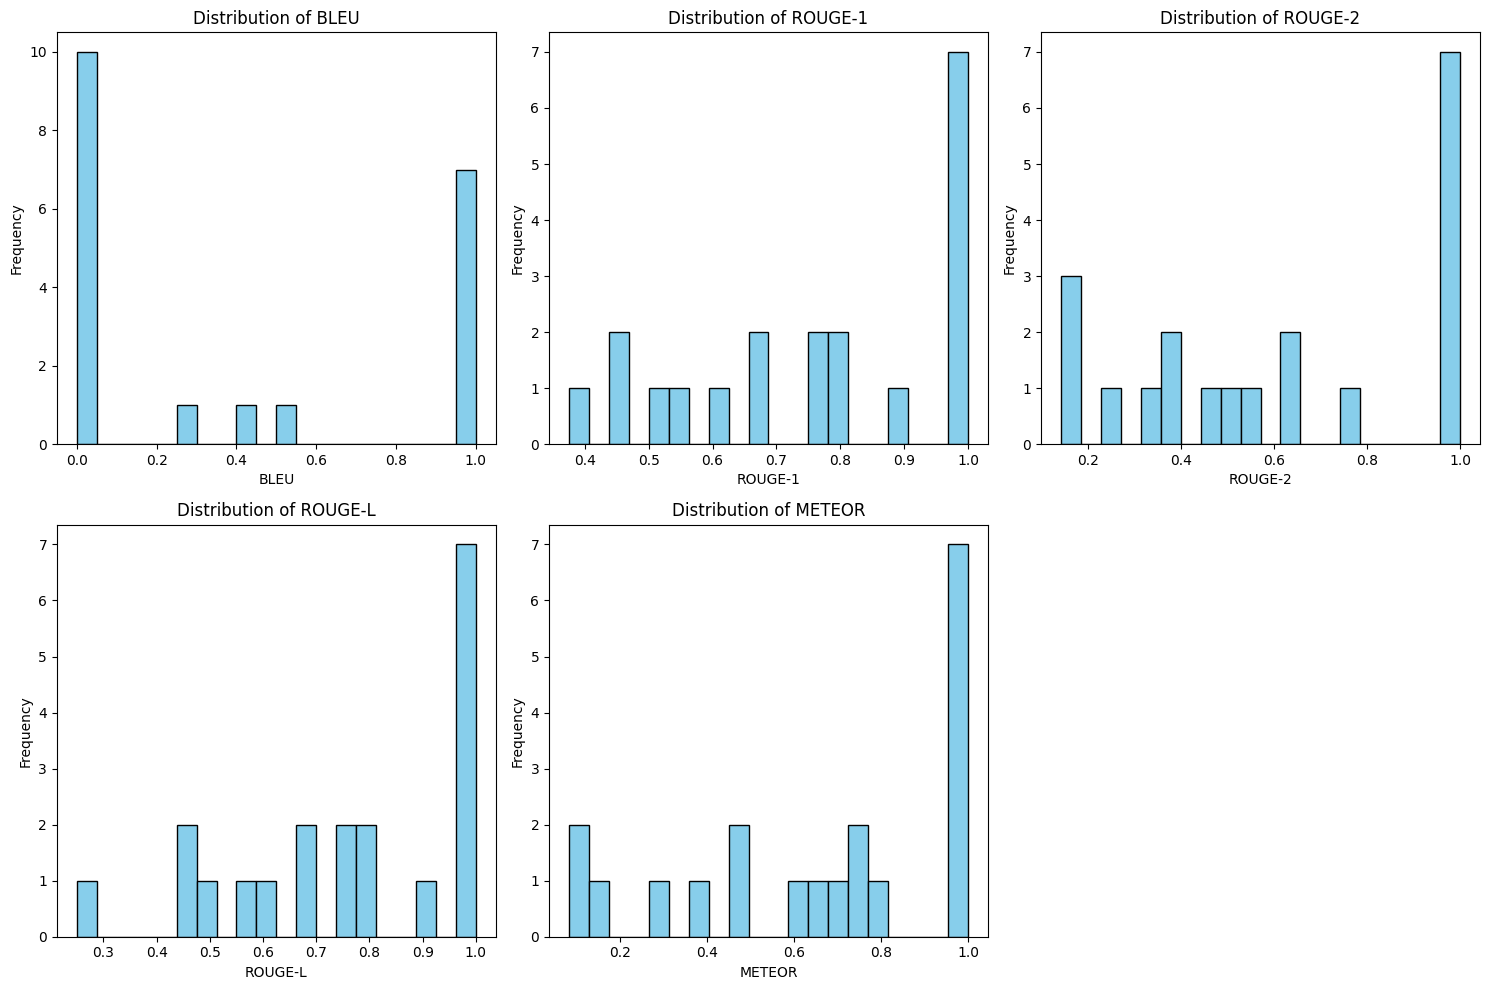

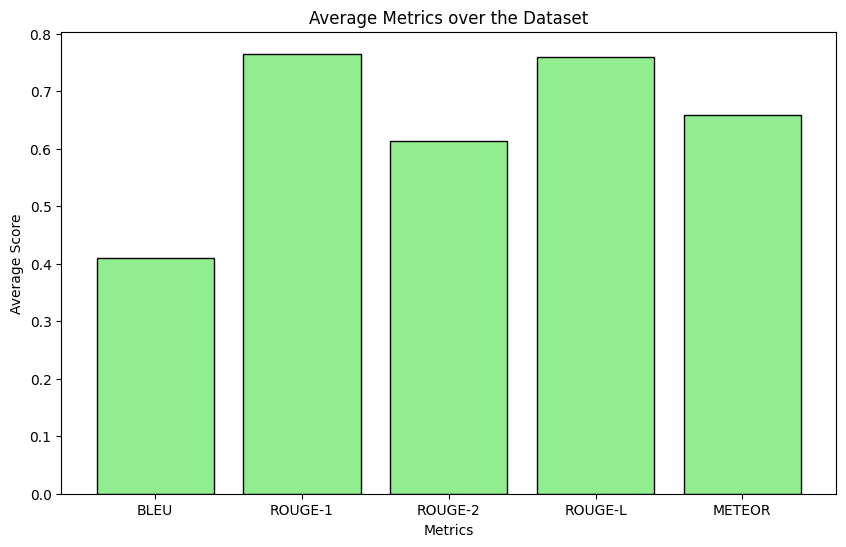

In [ ]:
# Plot the distribution of metrics and the average metrics.
plot_metrics_distribution(all_metrics)
plot_average_metrics(avg_metrics)

### Conclusion

The model can perform good translations of small sentences with few ambiguities. The model has some difficulties translating words like “at”, as they can have different translations and meanings in French. METEOR score is slight above 0.65 which indicates that the machine-generated translation is fairly close to alignment with human reference translations. However BLEU indicates that the translations are not so similar to the references.

## Final Conclusion

There are several types of architecture for translation. RNN does not seem to be sufficiently efficient for translation. GRU is an improvement on RNN, but still fails to generalize well. Transformers have potential for translation. But with a larger data set, they could lead to better performance.

---
# Not Part of TP3, But A Potential Project Idea: Understanding the Architecture of a Decoder-Only Transformer

Step 1: In a project group of 3-4 create a high level plan for a Decoder-Only model for how you would need to modify this code to implement a Decoder-Only Transformer. Key components of the implementation should be split up and each member of the group should present the pseudo-code (or actual code) for one component of the full model to one another, and in a report. Then create the working model and perform experiments comparing it with your TP3 encoder-decoder model.

For more details on the Decoder-Only Transformer see [this blog post](https://medium.com/international-school-of-ai-data-science/building-custom-gpt-with-pytorch-59e5ba8102d4). The [first "GPT" paper](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), and the paper cited by this GPT-1 paper for the Decoder Only architecture used for GPT, [i.e. this paper](https://arxiv.org/abs/1801.10198)